<a href="https://colab.research.google.com/github/ndthanhthuyf11/churn_prediction/blob/main/ChurnPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import lib & data

In [ ]:
#import general libraries
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
# !pip install category_encoders
# import category_encoders as ce
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.metrics import plot_confusion_matrix

import seaborn as sns
import graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import decomposition, datasets

#libs for random forest and decision tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#libs for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import statsmodels.api as sm

#libs for artificial neuron network
# from keras.wrappers.scikit_learn import KerasClassifier as keras
from tensorflow import keras
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier


In [ ]:
#connect drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#import & read data
df = pd.read_csv("/content/gdrive/Shareddrives/DA with R-Python/Dataset/internet_service_churn.csv")
df.rename(columns={'reamining_contract': 'remaining_contract'}, inplace=True)

#Functions

In [ ]:
def box_plots(df,col,nrow, ncol):
  plt.rcParams["figure.figsize"] = [20, 14]
  figure, axs = plt.subplots(nrow,ncol)
  count = 0
  for i in range(nrow):
    for j in range(ncol):
      if(count >= len(col)):
        break;
      else:
        axs[i,j].boxplot(df[col[count]])
        axs[i,j].set_title('Boxplot of {}'.format(col[count]))
        count+=1
  plt.show()

In [ ]:
def remove_outliers(df, col, min_quantile, max_quantile):
  min = df[col].quantile(min_quantile)
  max = df[col].quantile(max_quantile)
  range = max - min
  upper = max + 1.5 * range
  lower = min - 1.5 * range
  print('{0}:  upper {1} - lower {2}'.format(col, upper, lower))
  # print(df[(df[col] >= lower) & (df[col] <= upper)])
  return df[(df[col] >= lower) & (df[col] <= upper)]

# Describe & view data

In [ ]:
features = df.columns[1:]
#categorical columns with index 0,1,9
cat_features = features[[0,1,9]]
# numerical columns
num_features = features[~features.isin(cat_features)]
df.head(5)

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1


In [ ]:
num_features

Index(['subscription_age', 'bill_avg', 'remaining_contract',
       'service_failure_count', 'download_avg', 'upload_avg',
       'download_over_limit'],
      dtype='object')

In [ ]:
cat_features

Index(['is_tv_subscriber', 'is_movie_package_subscriber', 'churn'], dtype='object')

# EDA

## Overview

In [ ]:
#describe & view data
pd.options.display.float_format = '{:,.2f}'.format
df.describe()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
count,"72,274.00","72,274.00","72,274.00","72,274.00","72,274.00","50,702.00","72,274.00","71,893.00","71,893.00","72,274.00","72,274.00"
mean,"846,318.24",0.82,0.33,2.45,18.94,0.72,0.27,43.69,4.19,0.21,0.55
std,"489,102.17",0.39,0.47,2.03,13.22,0.70,0.82,63.41,9.82,1.00,0.50
min,15.00,0.00,0.00,-0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"422,216.50",1.00,0.00,0.93,13.00,0.00,0.00,6.70,0.50,0.00,0.00
50%,"847,784.00",1.00,0.00,1.98,19.00,0.57,0.00,27.80,2.10,0.00,1.00
75%,"1,269,562.00",1.00,1.00,3.30,22.00,1.31,0.00,60.50,4.80,0.00,1.00
max,"1,689,744.00",1.00,1.00,12.80,406.00,2.92,19.00,"4,415.20",453.30,7.00,1.00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72274 entries, 0 to 72273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           72274 non-null  int64  
 1   is_tv_subscriber             72274 non-null  int64  
 2   is_movie_package_subscriber  72274 non-null  int64  
 3   subscription_age             72274 non-null  float64
 4   bill_avg                     72274 non-null  int64  
 5   remaining_contract           50702 non-null  float64
 6   service_failure_count        72274 non-null  int64  
 7   download_avg                 71893 non-null  float64
 8   upload_avg                   71893 non-null  float64
 9   download_over_limit          72274 non-null  int64  
 10  churn                        72274 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.1 MB


In [ ]:
df.isna().sum()

id                                 0
is_tv_subscriber                   0
is_movie_package_subscriber        0
subscription_age                   0
bill_avg                           0
remaining_contract             21572
service_failure_count              0
download_avg                     381
upload_avg                       381
download_over_limit                0
churn                              0
dtype: int64

In [ ]:
# churn of customer who have bill_avg=0
df[df.bill_avg == 0].value_counts('churn')

churn
1    4793
0     380
dtype: int64

In [ ]:
# check if customer has no contract but using service
df[df.remaining_contract.isnull()].value_counts('churn')

churn
1    19719
0     1853
dtype: int64

##**Distributions of features**

In [ ]:
# %matplotlib inline
# df[features].hist(bins=50, figsize=(20, 15));

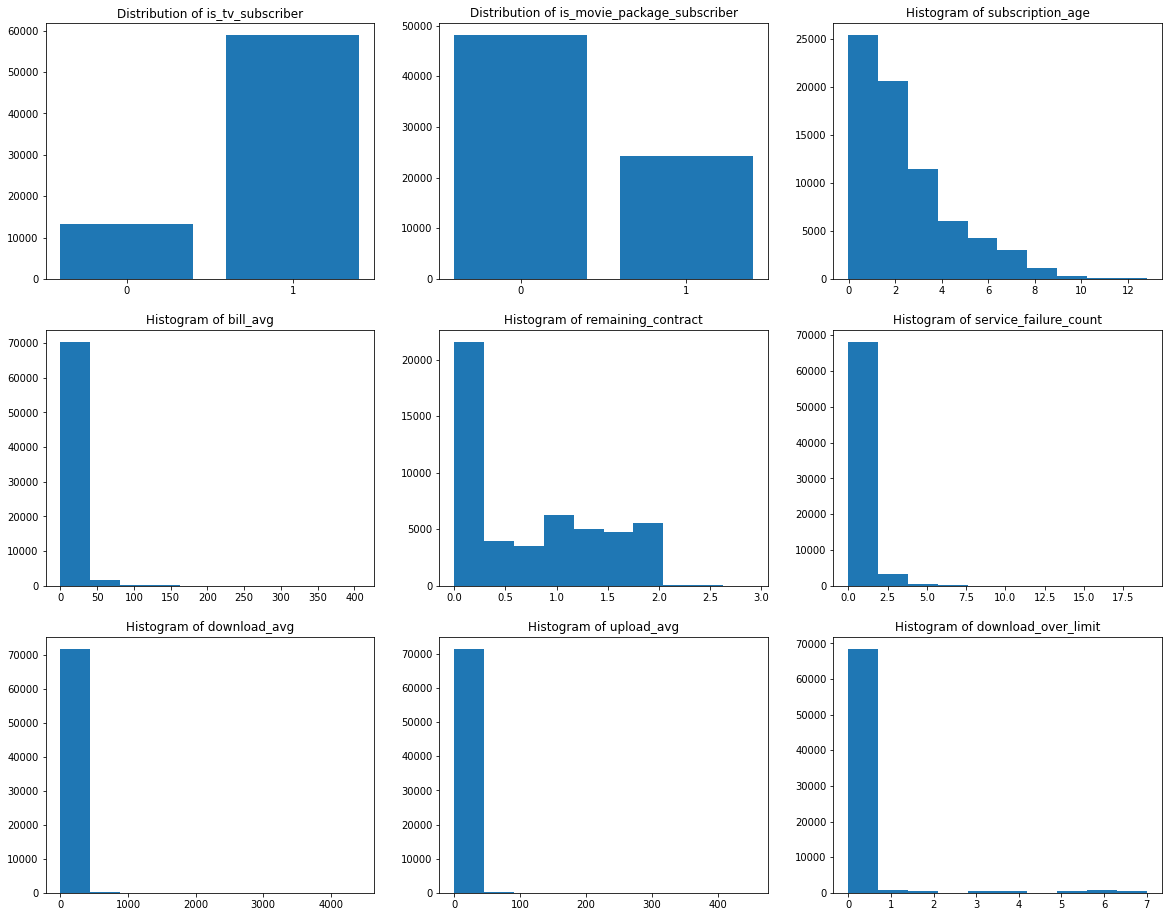

In [ ]:
plt.rcParams["figure.figsize"] = [20, 16]
figure, axs = plt.subplots(3,3)
count = 0
for i in range(3):
  for j in range(3):
    if(count >= len(features)):
      break
    if features[count] in num_features:
      axs[i,j].hist(df[features[count]])
      axs[i,j].set_title('Histogram of {}'.format(features[count]))

    else:
      df_sub = pd.DataFrame(data={'value': df[features[count]].unique(), 'counts':df[features[count]].value_counts()})
      axs[i,j].bar(df_sub['value'], df_sub['counts'])
      axs[i,j].set_xticks(df_sub['value'])
      axs[i,j].set_title('Distribution of {}'.format(features[count]))

    count+=1

plt.show()

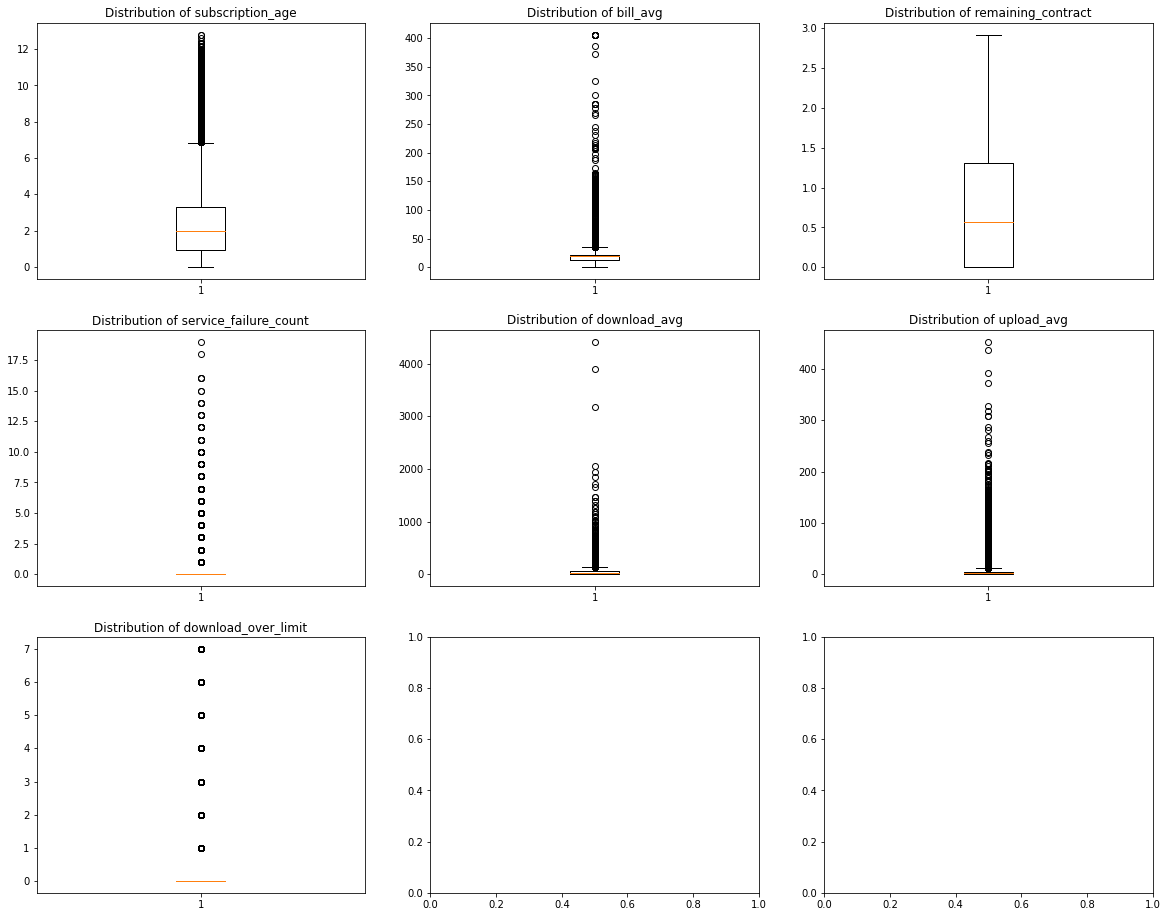

In [ ]:
plt.rcParams["figure.figsize"] = [20, 16]
figure, axs = plt.subplots(3,3)
count = 0
for i in range(3):
  for j in range(3):
    if(count >= len(num_features)):
      break;
    #if col has NaN, drop NaN them plot boxplot
    if df[num_features[count]].isnull().sum() > 0:
      df_sub = df[num_features[count]].dropna()
      axs[i,j].boxplot(df_sub)
    else:
      axs[i,j].boxplot(df[num_features[count]])

    axs[i,j].set_title('Distribution of {}'.format(num_features[count]))
    count+=1

plt.show()

In [ ]:
# columns = ["churn", "subscription_age", "service_failure_count", "bill_avg"]
# scatter_matrix(df[columns], figsize=(12,10), hist_kwds={'bins': 20});

In [ ]:
# sn.pairplot(df[features])

## Analysis about customer and factors that affect to churn rate

**Count of customers using the service**

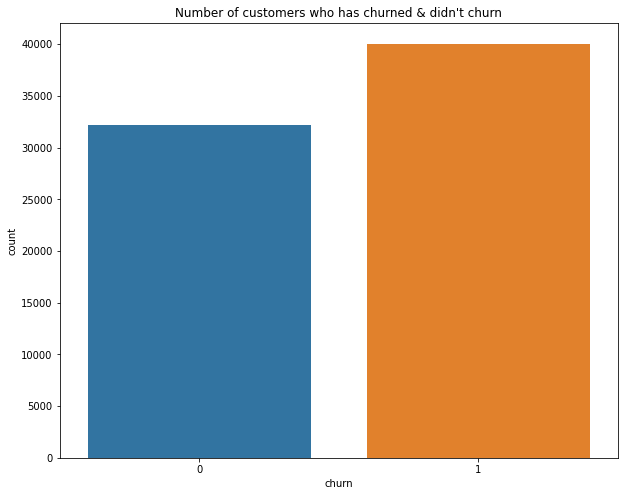

In [ ]:
plt.rcParams["figure.figsize"] = [10, 8]
plt.title("Number of customers who has churned & didn't churn")
sn.countplot(x = 'churn' ,  data = df)

**Current status of customers using the service**

1.   Count of customers who use TV and moview package


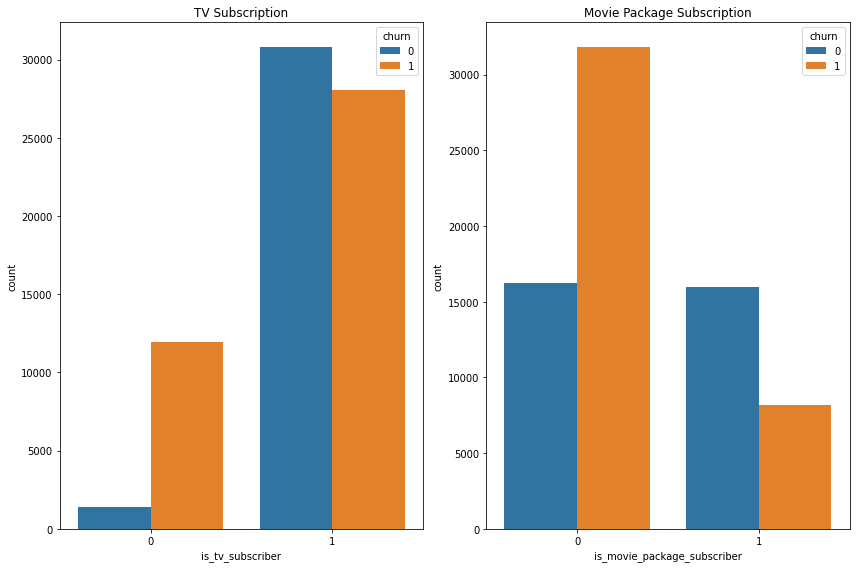

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Tv subscription or not
sn.countplot(data = df, x = 'is_tv_subscriber', hue = 'churn', ax=axes[0])
axes[0].set_title("TV Subscription")

# Movie package subscription or not
sn.countplot(data = df, x = 'is_movie_package_subscriber', hue = 'churn', ax=axes[1])
axes[1].set_title('Movie Package Subscription')
fig.tight_layout()

In [ ]:
# customers who using both TV and movie package
df.groupby('is_tv_subscriber')['is_movie_package_subscriber'].value_counts()

is_tv_subscriber  is_movie_package_subscriber
0                 0                              13350
                  1                                  2
1                 0                              34739
                  1                              24183
Name: is_movie_package_subscriber, dtype: int64

2.   Download & Upload average

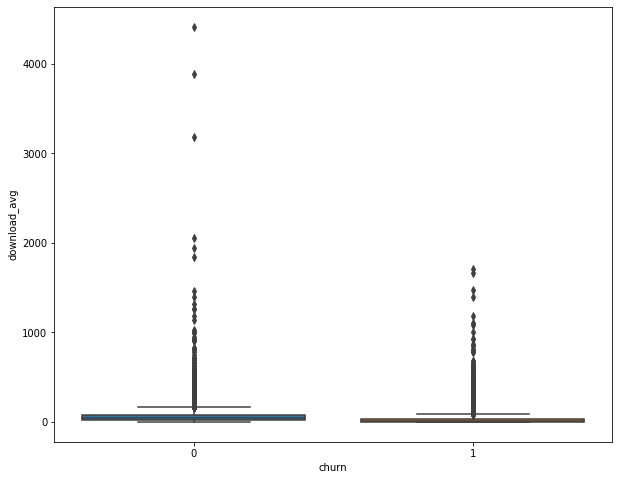

In [ ]:
plt.rcParams["figure.figsize"] = [10, 8]
sn.boxplot(x="churn",y="download_avg",data=df)
plt.show()

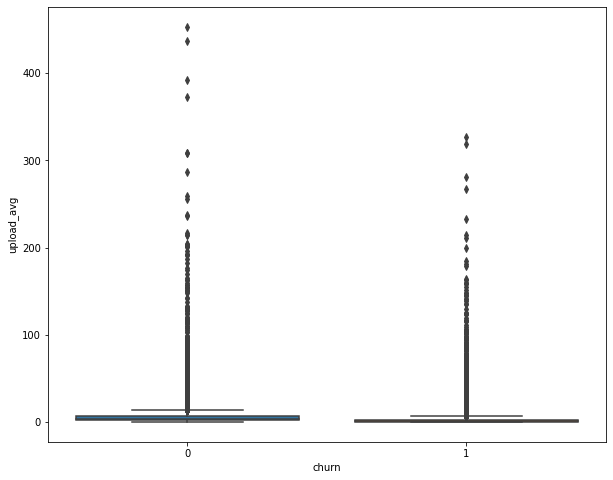

In [ ]:
plt.rcParams["figure.figsize"] = [10, 8]
sn.boxplot(x="churn",y="upload_avg",data=df)
plt.show()



3. Count of customers have a download limit



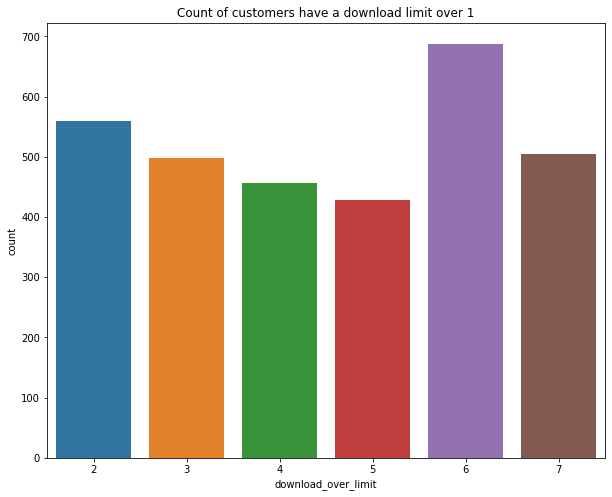

In [ ]:
data = df[df['download_over_limit'] > 1]

plt.rcParams["figure.figsize"] = [10, 8]
plt.title("Count of customers have a download limit over 1")
sn.countplot(x = 'download_over_limit' ,  data = data)

4. Counts of customer call to the center for service failure


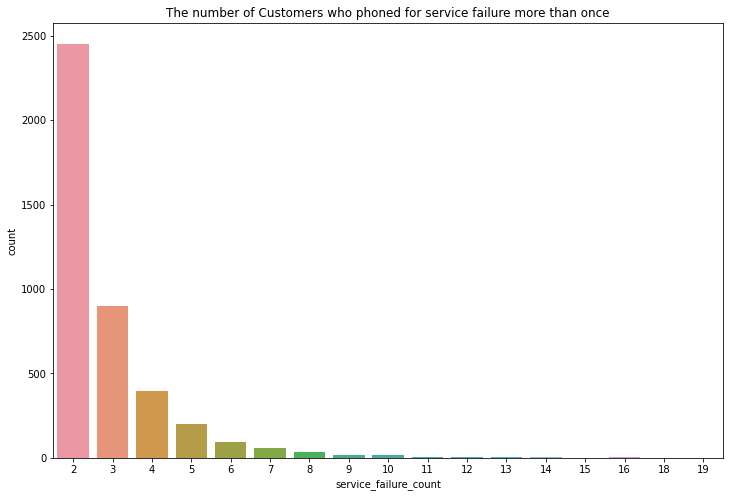

In [ ]:
data = df[df['service_failure_count'] > 1]
plt.figure(figsize = (12,8))
sn.countplot(data = data, x = 'service_failure_count')
plt.title('The number of Customers who phoned for service failure more than once')
plt.show()

**Customer**


1.   Bill Average



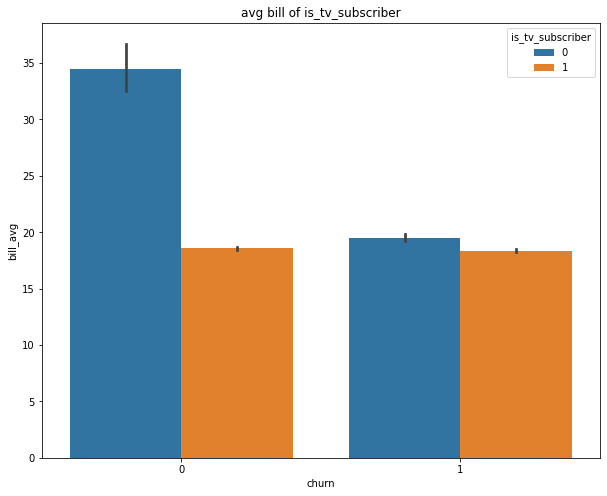

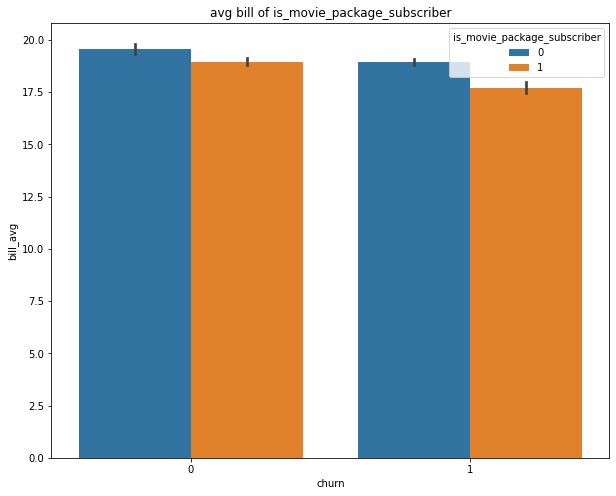

In [ ]:
subscribers=["is_tv_subscriber","is_movie_package_subscriber"]
plt.rcParams["figure.figsize"] = [10, 8]
for i in subscribers:
    sn.barplot(x="churn",y="bill_avg",data=df,hue=i)
    plt.title("avg bill of "+ i)
    plt.show()

In [ ]:


# for i in subscribers:
#     sn.barplot(x="churn",y="bill_avg",data=df,hue=i)
#     plt.title("avg bill of "+ i)
#     plt.show()

# figure, axs = plt.subplots(1,2)
# for i in range(2):
#     axs[0,i].bar('churn','bill_avg',data=df)
#     # ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
#     plt.title("avg bill of "+ subscribers[i])


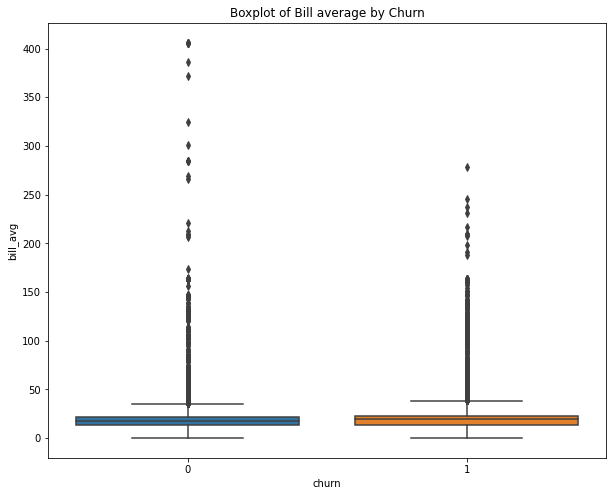

In [ ]:
plt.rcParams["figure.figsize"] = [10, 8]
sn.boxplot(x="churn",y="bill_avg",data=df)
plt.title("Boxplot of Bill average by Churn")
plt.show()




2.   Subcription age



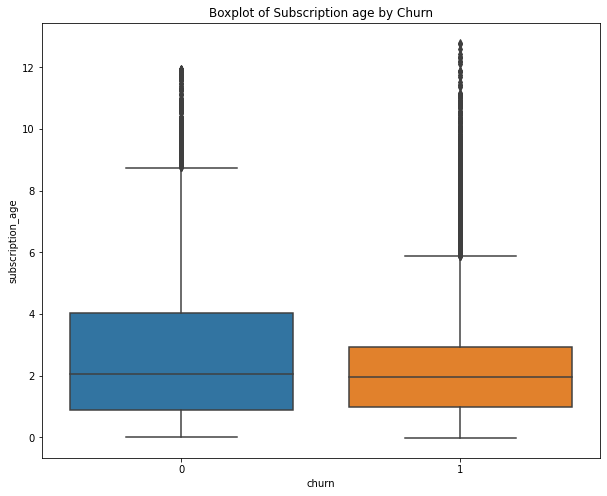

In [ ]:
sn.boxplot(x="churn",y="subscription_age",data=df)
plt.title("Boxplot of Subscription age by Churn")
plt.show()

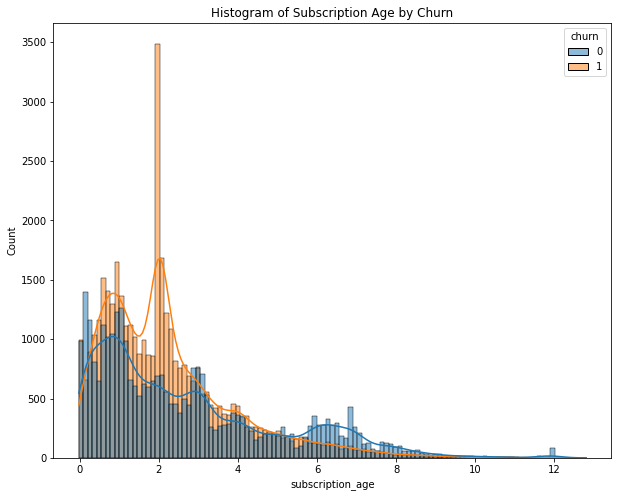

In [ ]:
plt.figure(figsize = (10,8))
sn.histplot(data = df, x= 'subscription_age', kde = True, hue = 'churn')
plt.title('Histogram of Subscription Age by Churn')
plt.show()

3. Remaining contract

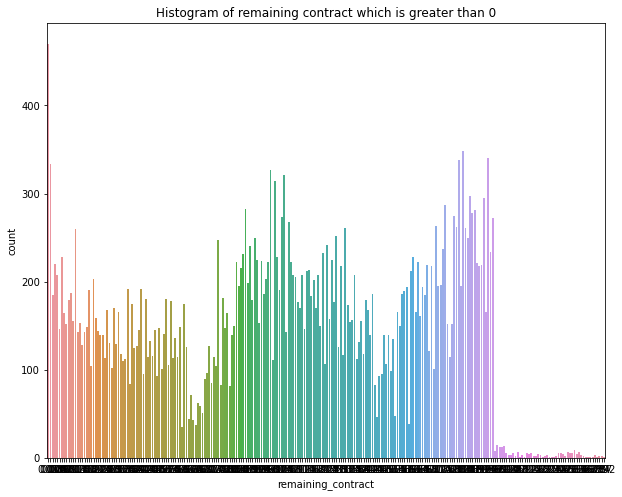

In [ ]:
data = df[df['remaining_contract'] > 0]
plt.figure(figsize = (10,8))
sn.countplot(data = data, x = 'remaining_contract')
plt.title('Histogram of remaining contract which is greater than 0')
plt.show()

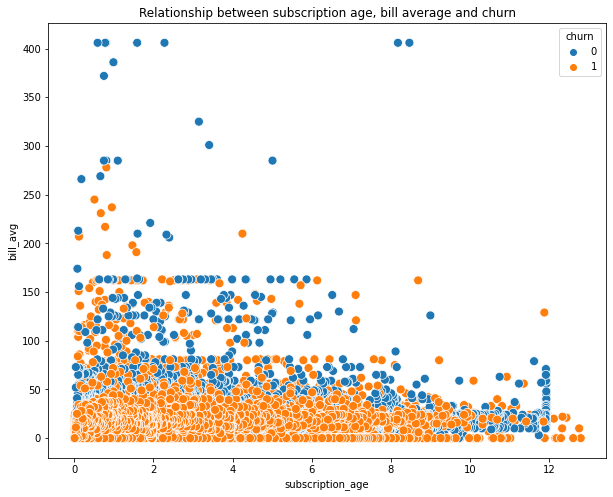

In [ ]:
plt.figure(figsize = (10,8))
sn.scatterplot(x="subscription_age", y="bill_avg", hue="churn", data=df, s=80)
plt.title("Relationship between subscription age, bill average and churn")
plt.show()

## Find the correlation among the variables

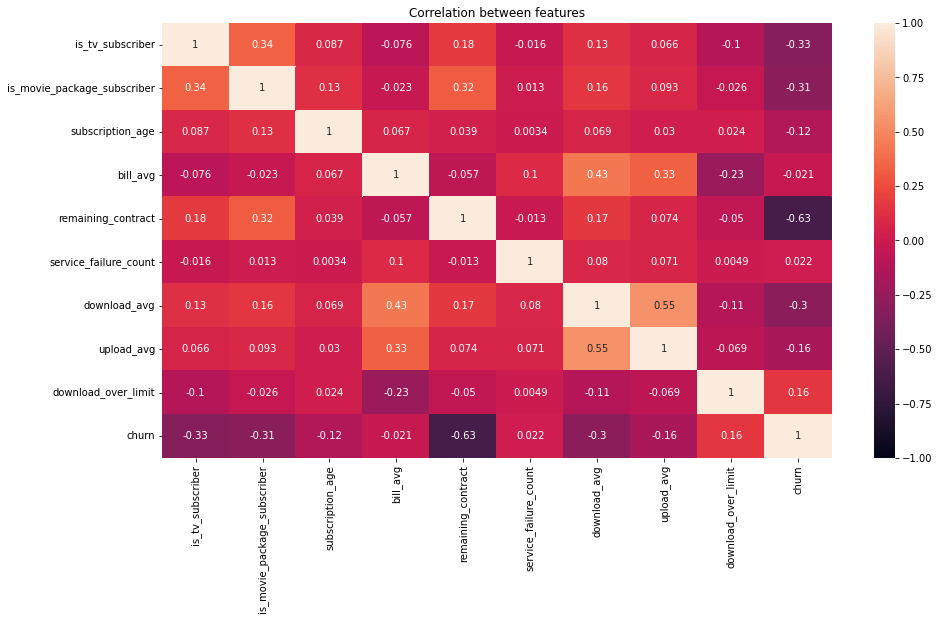

In [ ]:
plt.figure(figsize=(15,8))
sn.heatmap(df[features].corr(),vmin=-1,vmax=1,annot=True)
plt.title("Correlation between features")
plt.show()

#Preprocessing




##Duplicates

In [ ]:
print('Duplicates:', df.duplicated().sum())
print('Duplicates of id:', df.duplicated('id').sum())

Duplicates: 0
Duplicates of id: 0


##Error values

From descriptive statistics, it is noticable that subscription_age has negative values -> an error due to data entry or data constraints

In [ ]:
df[df.subscription_age < 0]

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
69320,1621523,0,0,-0.02,0,0.08,0,32.6,1.3,0,1


In [ ]:
df = df[df.subscription_age	>= 0]

##Missing values

###Check missing values

In [ ]:
# calculate null values(
df.isna().sum()

id                                 0
is_tv_subscriber                   0
is_movie_package_subscriber        0
subscription_age                   0
bill_avg                           0
remaining_contract             21572
service_failure_count              0
download_avg                     381
upload_avg                       381
download_over_limit                0
churn                              0
dtype: int64

The remaining_contract has around 21572 blank values which means these are the number of customers who dont have contract. The blank values can be filled with 0 to easily analysis in the next steps.
=>
(1) Drop 381 blank values of "download_avg" and "upload_avg".
(2) Create a new column called **"is_contract"** which shows whether the customer opted for contract (1) or not (0).


###Handling null values

Drop 381 null values of "download_avg" and "upload_avg"

In [ ]:
#Drop the null values
df.dropna(subset=['download_avg'], inplace=True)
df.dropna(subset=['upload_avg'], inplace=True)

Handling 21,572 blank values of column "remaining_contract"

In [ ]:
#insert new column name
# test_cols = df.columns.tolist()
# test_cols.insert(5, 'is_contract')
features = features.insert(5, 'is_contract')

# Create is_contract column
df['is_contract'] = df['remaining_contract'].apply(lambda x: 0 if pd.isna(x) else 1)
# replace null with 0
df['remaining_contract'].replace(np.nan, 0, inplace=True)
# arrange the cols
# test_prepared = df[test_cols]
cols = ['id','is_tv_subscriber','is_movie_package_subscriber','subscription_age','bill_avg','remaining_contract',
                'is_contract','service_failure_count','download_avg','upload_avg','download_over_limit','churn']

df = df.reindex(columns = cols)

In [ ]:
#recheck the dataframe
df.head()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,is_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,1,0,8.4,2.3,0,0
1,18,0,0,8.22,0,0.00,0,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,1,0,13.7,0.9,0,1
3,27,0,0,6.87,21,0.00,0,1,0.0,0.0,0,1
4,34,0,0,6.39,0,0.00,0,0,0.0,0.0,0,1


In [ ]:
#recheck null values
df.isna().sum()

id                             0
is_tv_subscriber               0
is_movie_package_subscriber    0
subscription_age               0
bill_avg                       0
remaining_contract             0
is_contract                    0
service_failure_count          0
download_avg                   0
upload_avg                     0
download_over_limit            0
churn                          0
dtype: int64

In [ ]:
#check overall again
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71893 entries, 0 to 72273
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           71893 non-null  int64  
 1   is_tv_subscriber             71893 non-null  int64  
 2   is_movie_package_subscriber  71893 non-null  int64  
 3   subscription_age             71893 non-null  float64
 4   bill_avg                     71893 non-null  int64  
 5   remaining_contract           71893 non-null  float64
 6   is_contract                  71893 non-null  int64  
 7   service_failure_count        71893 non-null  int64  
 8   download_avg                 71893 non-null  float64
 9   upload_avg                   71893 non-null  float64
 10  download_over_limit          71893 non-null  int64  
 11  churn                        71893 non-null  int64  
dtypes: float64(4), int64(8)
memory usage: 7.1 MB


If the count of non-null values of all column is 71893 --> Handling missing value DONE

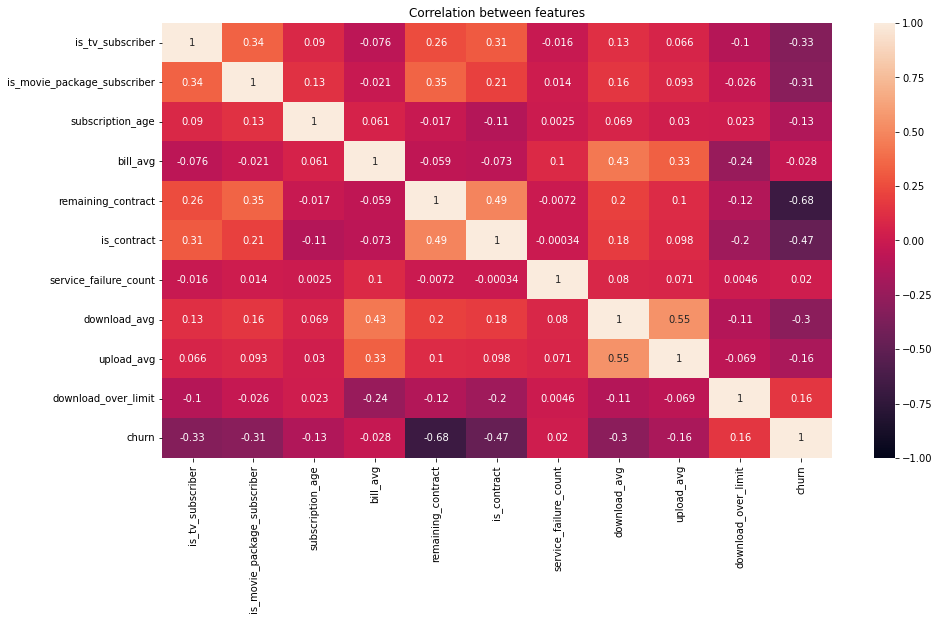

In [ ]:
plt.figure(figsize=(15,8))
sn.heatmap(df[features].corr(),vmin=-1,vmax=1,annot=True)
plt.title("Correlation between features")
plt.show()

##Outlier analysis

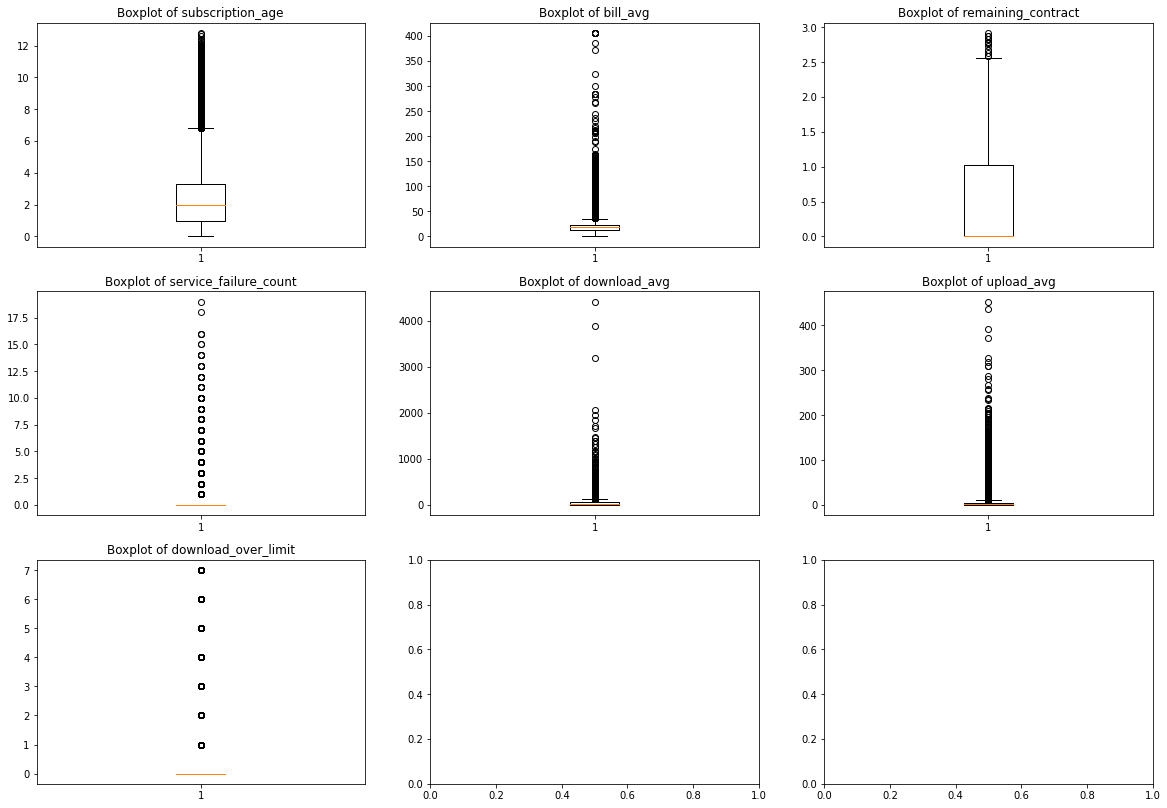

In [ ]:
box_plots(df, num_features, 3, 3)

In [ ]:
df.describe()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,is_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
count,7.189300e+04,71893.000000,71893.000000,71893.000000,71893.000000,71893.000000,71893.000000,71893.000000,71893.000000,71893.000000,71893.000000,71893.000000
mean,8.432896e+05,0.815225,0.334066,2.455486,19.016844,0.497612,0.700694,0.275674,43.689911,4.192076,0.208713,0.557078
std,4.871708e+05,0.388117,0.471666,2.026856,13.188541,0.665755,0.457957,0.818533,63.405963,9.818896,0.999647,0.496735
min,1.500000e+01,0.000000,0.000000,-0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.211420e+05,1.000000,0.000000,0.940000,13.000000,0.000000,0.000000,0.000000,6.700000,0.500000,0.000000,0.000000
50%,8.447570e+05,1.000000,0.000000,1.980000,19.000000,0.000000,1.000000,0.000000,27.800000,2.100000,0.000000,1.000000
75%,1.264775e+06,1.000000,1.000000,3.300000,22.000000,1.030000,1.000000,0.000000,60.500000,4.800000,0.000000,1.000000
max,1.689744e+06,1.000000,1.000000,12.800000,406.000000,2.920000,1.000000,19.000000,4415.200000,453.300000,7.000000,1.000000


**Outlier removal with percentile of 25-75**

In [ ]:
df1 = df.copy()
for i in num_features:
  df1 = remove_outliers(df1, i, 0.25, 0.75)
  print("Removing outliers at {0} - shape {1} \n".format(i, df1.shape))

subscription_age:  upper 6.84 - lower -2.6
Removing outliers at subscription_age - shape (68690, 12) 

bill_avg:  upper 35.5 - lower -0.5
Removing outliers at bill_avg - shape (65440, 12) 

remaining_contract:  upper 2.575 - lower -1.545
Removing outliers at remaining_contract - shape (65426, 12) 

service_failure_count:  upper 0.0 - lower 0.0
Removing outliers at service_failure_count - shape (55014, 12) 

download_avg:  upper 130.14999999999998 - lower -69.44999999999999
Removing outliers at download_avg - shape (52660, 12) 

upload_avg:  upper 9.4 - lower -5.0
Removing outliers at upload_avg - shape (50108, 12) 

download_over_limit:  upper 0.0 - lower 0.0
Removing outliers at download_over_limit - shape (47151, 12) 



Boxplot after removing outliers

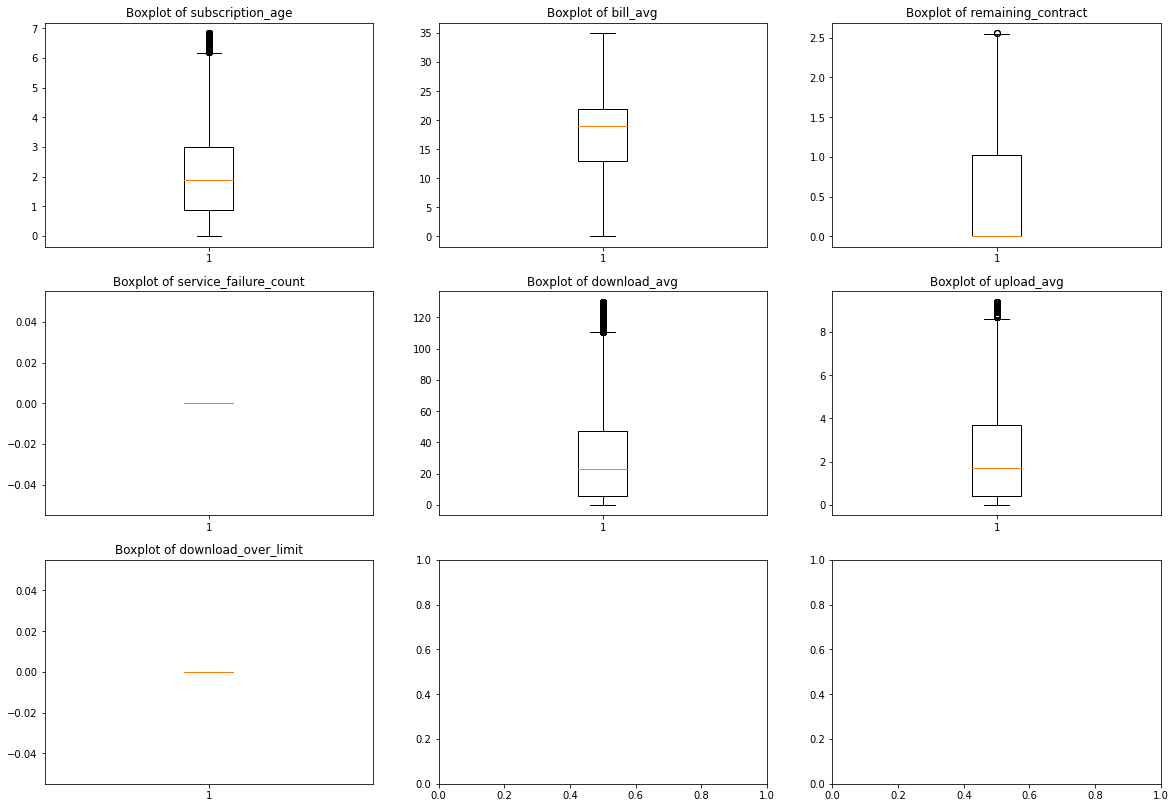

In [ ]:
box_plots(df1, num_features, 3, 3)

**Outlier removal with percentile of 5-95**

In [ ]:
df2 = df.copy()
for i in num_features:
  df2 = remove_outliers(df2, i, 0.05, 0.95)
  print("Removing at {0} - shape {1} \n".format(i, df2.shape))

subscription_age:  upper 16.54 - lower -9.620000000000001
Removing at subscription_age - shape (71893, 12) 

bill_avg:  upper 85.0 - lower -51.0
Removing at bill_avg - shape (71622, 12) 

remaining_contract:  upper 4.6000000000000005 - lower -2.7600000000000002
Removing at remaining_contract - shape (71622, 12) 

service_failure_count:  upper 5.0 - lower -3.0
Removing at service_failure_count - shape (71378, 12) 

download_avg:  upper 342.0 - lower -205.20000000000002
Removing at download_avg - shape (71237, 12) 

upload_avg:  upper 31.5 - lower -18.9
Removing at upload_avg - shape (70598, 12) 

download_over_limit:  upper 2.5 - lower -1.5
Removing at download_over_limit - shape (68037, 12) 



Boxplot after removing outliers

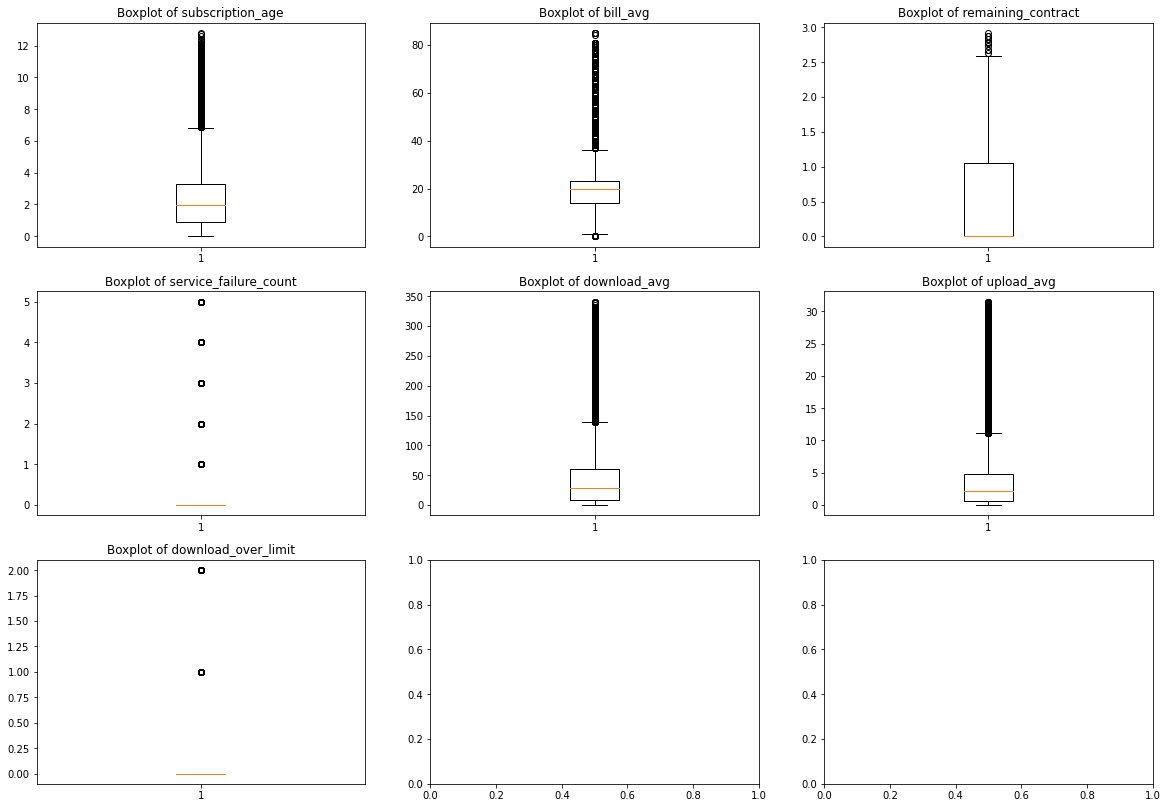

In [ ]:
box_plots(df2, num_features, 3, 3)

**Outlier removal (mixed)**

In [ ]:
df3 = df.copy()
for i in num_features[[0,1,2,4,5]]:
  df3 = remove_outliers(df3, i, 0.25, 0.75)
  print("Removing at {0} - shape {1} \n".format(i, df3.shape))

subscription_age:  upper 6.84 - lower -2.6
Removing at subscription_age - shape (68690, 12) 

bill_avg:  upper 35.5 - lower -0.5
Removing at bill_avg - shape (65440, 12) 

remaining_contract:  upper 2.575 - lower -1.545
Removing at remaining_contract - shape (65426, 12) 

download_avg:  upper 133.25 - lower -70.35
Removing at download_avg - shape (62635, 12) 

upload_avg:  upper 9.649999999999999 - lower -5.1499999999999995
Removing at upload_avg - shape (59524, 12) 



In [ ]:
for i in num_features[[3,6]]:
  df3 = remove_outliers(df3, i, 0.05, 0.95)
  print("Removing at {0} - shape {1} \n".format(i, df3.shape))

service_failure_count:  upper 5.0 - lower -3.0
Removing at service_failure_count - shape (59351, 12) 

download_over_limit:  upper 2.5 - lower -1.5
Removing at download_over_limit - shape (56910, 12) 



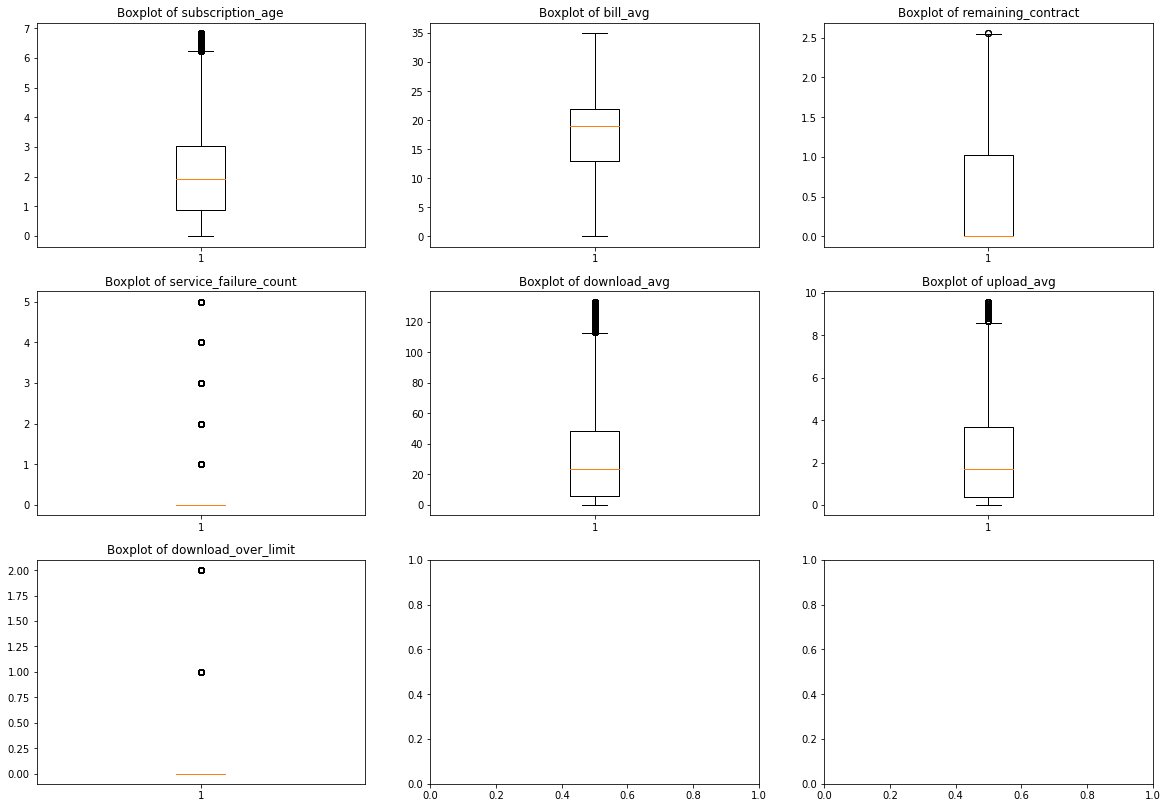

In [ ]:
box_plots(df3, num_features, 3, 3)

In [ ]:
df1.describe()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,is_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
count,4.715000e+04,47150.000000,47150.000000,47150.000000,47150.000000,47150.000000,47150.000000,47150.0,47150.000000,47150.000000,47150.0,47150.000000
mean,8.930358e+05,0.820573,0.308929,2.148217,17.452365,0.493823,0.713892,0.0,30.825224,2.340581,0.0,0.571113
std,4.676868e+05,0.383714,0.462057,1.640776,6.939736,0.664603,0.451945,0.0,29.674492,2.272800,0.0,0.494922
min,3.400000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
25%,5.024768e+05,1.000000,0.000000,0.880000,13.000000,0.000000,0.000000,0.0,5.700000,0.400000,0.0,0.000000
50%,9.025630e+05,1.000000,0.000000,1.890000,19.000000,0.000000,1.000000,0.0,23.000000,1.700000,0.0,1.000000
75%,1.292976e+06,1.000000,1.000000,3.000000,22.000000,1.020000,1.000000,0.0,47.600000,3.700000,0.0,1.000000
max,1.689744e+06,1.000000,1.000000,6.840000,35.000000,2.560000,1.000000,0.0,130.100000,9.400000,0.0,1.000000


In [ ]:
df2.describe()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,is_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
count,6.803600e+04,68036.000000,68036.000000,68036.000000,68036.000000,68036.000000,68036.000000,68036.000000,68036.000000,68036.000000,68036.000000,68036.000000
mean,8.617265e+05,0.824064,0.334808,2.446861,18.918734,0.512526,0.717943,0.244562,41.942802,3.502846,0.027236,0.544447
std,4.820173e+05,0.380769,0.471927,2.038753,9.199365,0.670044,0.450004,0.665408,45.631680,4.243338,0.206691,0.498024
min,1.500000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.509812e+05,1.000000,0.000000,0.920000,14.000000,0.000000,0.000000,0.000000,8.100000,0.600000,0.000000,0.000000
50%,8.687455e+05,1.000000,0.000000,1.980000,20.000000,0.000000,1.000000,0.000000,28.700000,2.200000,0.000000,1.000000
75%,1.277740e+06,1.000000,1.000000,3.290000,23.000000,1.050000,1.000000,0.000000,60.200000,4.800000,0.000000,1.000000
max,1.689744e+06,1.000000,1.000000,12.800000,85.000000,2.920000,1.000000,5.000000,341.000000,31.500000,2.000000,1.000000


In [ ]:
df3.describe()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,is_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
count,5.690900e+04,56909.000000,56909.000000,56909.000000,56909.000000,56909.000000,56909.000000,56909.000000,56909.000000,56909.000000,56909.000000,56909.000000
mean,8.795004e+05,0.816778,0.311128,2.165310,17.495932,0.489122,0.709396,0.227837,31.511339,2.398763,0.028730,0.577589
std,4.706982e+05,0.386852,0.462959,1.654235,7.048168,0.664419,0.454045,0.638823,30.327763,2.323221,0.212924,0.493948
min,3.400000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.842060e+05,1.000000,0.000000,0.880000,13.000000,0.000000,0.000000,0.000000,5.900000,0.400000,0.000000,0.000000
50%,8.796870e+05,1.000000,0.000000,1.900000,19.000000,0.000000,1.000000,0.000000,23.600000,1.700000,0.000000,1.000000
75%,1.283969e+06,1.000000,1.000000,3.020000,22.000000,1.020000,1.000000,0.000000,48.700000,3.700000,0.000000,1.000000
max,1.689744e+06,1.000000,1.000000,6.840000,35.000000,2.560000,1.000000,5.000000,133.200000,9.600000,2.000000,1.000000


In [ ]:
df.service_failure_count.value_counts()

0     60026
1      7664
2      2453
3       901
4       395
5       201
6        97
7        58
8        37
9        17
10       15
11        6
12        6
13        5
14        4
16        3
15        2
19        1
18        1
Name: service_failure_count, dtype: int64

In [ ]:
df1.service_failure_count.value_counts()

0    47150
Name: service_failure_count, dtype: int64

In [ ]:
df2.service_failure_count.value_counts()

0    57160
1     7213
2     2290
3      833
4      353
5      187
Name: service_failure_count, dtype: int64

In [ ]:
df1.churn.value_counts(normalize=True)

1    0.571113
0    0.428887
Name: churn, dtype: float64

In [ ]:
df2.churn.value_counts(normalize=True)

1    0.544447
0    0.455553
Name: churn, dtype: float64

In [ ]:
df3.churn.value_counts(normalize=True)

1    0.577589
0    0.422411
Name: churn, dtype: float64

#Export csv file for further steps

In [ ]:
path ='/content/gdrive/Shareddrives/DA with R-Python/0.Project/Source code/asset/internet_churn'

# df.to_csv(path+"cleaned"+'.csv', index=False, header=True)
# df1.to_csv(path+"cleaned2575"+'.csv', index=False, header=True)
# df2.to_csv(path+"cleaned0595"+'.csv', index=False, header=True)
# df3.to_csv(path+"cleaned_mixed"+'.csv', index=False, header=True)

# Modelling

In [ ]:
X = df3.drop(columns=['churn', 'id'])
y = df3['churn']

#split train:test = 7:3
X_train_org, X_test_org, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train = X_train_org.copy()
X_test = X_test_org.copy()
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.fit_transform(X_test[num_features])

In [ ]:
X_train[num_features].head(3)

,subscription_age,bill_avg,remaining_contract,service_failure_count,download_avg,upload_avg,download_over_limit
41444,-0.110560,0.638804,-0.736545,1.181270,0.700197,-0.042990,-0.133176
43171,0.458445,0.353854,0.755460,-0.357789,-0.174311,-0.645752,-0.133176
18811,0.325273,0.781278,-0.736545,-0.357789,-0.674029,0.086174,-0.133176


In [ ]:
X_train_org.head(3)

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,is_contract,service_failure_count,download_avg,upload_avg,download_over_limit
41444,1,0,1.98,22,0.00,0,1,52.9,2.3,0
43171,1,0,2.92,20,0.99,1,0,26.3,0.9,0
18811,1,0,2.70,23,0.00,0,0,11.1,2.6,0


# Logistic Regression

In [ ]:
# Modelling Logistic regression
model_log = LogisticRegression()
model_log.fit(X_train_org, y_train)
y_pred = model_log.predict(X_test_org)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
lr_pred= model_log.predict(X_test_org)
report = classification_report(y_test,lr_pred)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      7184
           1       0.89      0.91      0.90      9889

    accuracy                           0.88     17073
   macro avg       0.88      0.88      0.88     17073
weighted avg       0.88      0.88      0.88     17073



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


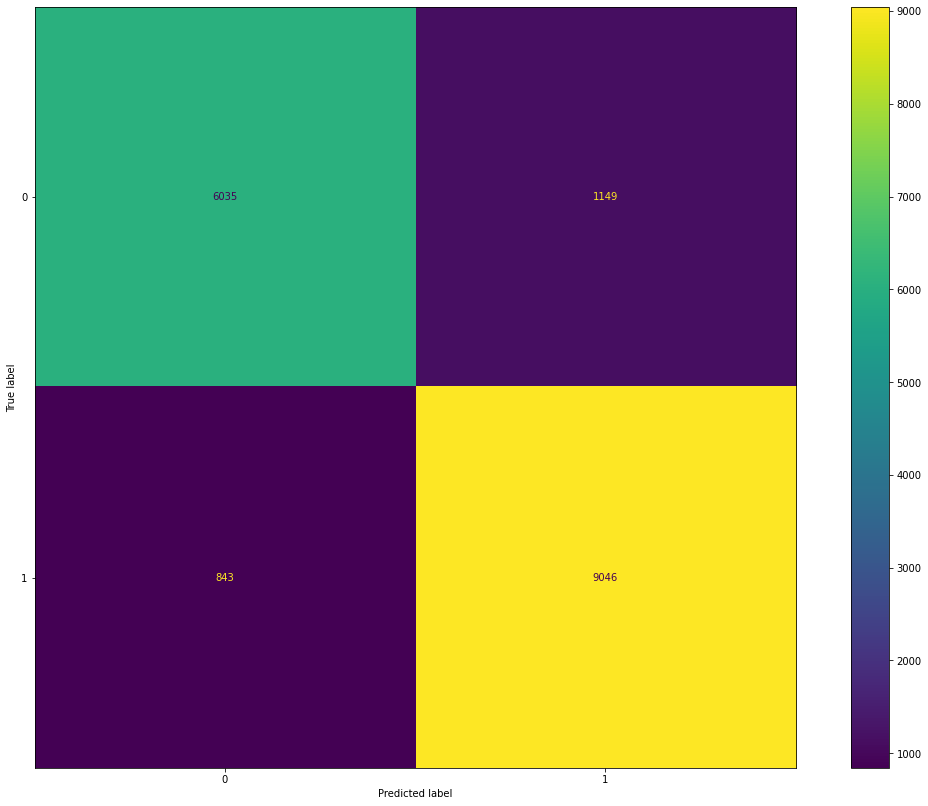

In [ ]:
# plot confusion matrix
plot_confusion_matrix(model_log, X_test_org, y_test)

## Feature selection



* Correlation
* Coeffiencts

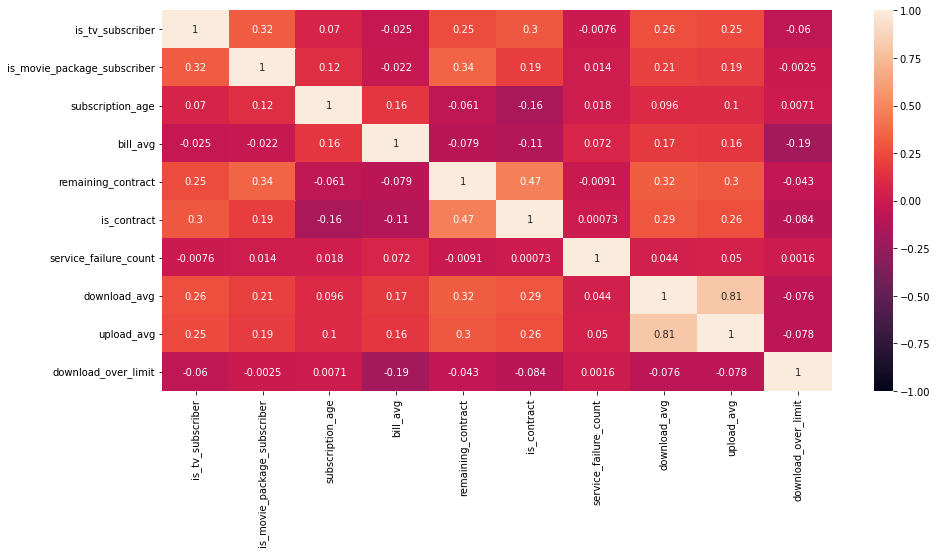

In [ ]:
corrmat = X_train_org.corr()
# plot
fig, ax = plt.subplots()
fig.set_size_inches(15,7)
sns.heatmap(corrmat,vmin=-1,vmax=1,annot=True)

In [ ]:
def correlation(df, threshold):
 col_corr = set()
 corrmat = df.corr()
 print("Feature(s) that experience(s) multicolinearity:")
 for i in range(len(corrmat.columns)):
   for j in range(i):
   # interested in abs coefficient values
     if abs(corrmat.iloc[i, j]) > threshold:
        print(corrmat.columns[i])
        col_corr.add(corrmat.columns[i])
 return col_corr

corr_feats = correlation(X_train_org, 0.6)
#drop feature(s)
X_train_log = X_train_org.drop(labels=corr_feats, axis=1)

Feature(s) that experience(s) multicolinearity:
upload_avg


In [ ]:
X_train_log.columns

Index(['is_tv_subscriber', 'is_movie_package_subscriber', 'subscription_age',
       'bill_avg', 'remaining_contract', 'is_contract',
       'service_failure_count', 'download_avg', 'download_over_limit'],
      dtype='object')

In [ ]:
X_test_log = X_test_org.drop('upload_avg', axis = 1)

### Weight of Evidence

In [ ]:
# feature = 'is_contract'
# target = 'churn'
# df_woe_iv = (pd.crosstab(df3[feature],df3[target], normalize='columns')
#              .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
#              .assign(iv=lambda dfx: np.sum(dfx['woe']*(dfx[1]-dfx[0]))))

# df_woe_iv

Information Value	Predictive power

* <0.02:	      Useless

* 0.02 to 0.1:	Weak predictors

* 0.1 to 0.3:	Medium Predictors

* 0.3 to 0.5:	Strong predictors

* '> 0.5:	      Suspicious


-> feature 'is_movie_package_subscriber' have strong predictors for the model but feature 'is_movie_package_subscriber'

### Feature Importance

In [ ]:
scaler = StandardScaler()
X_train_log[X_train_log.columns] = scaler.fit_transform(X_train_log[X_train_log.columns])
X_test_log[X_train_log.columns] = scaler.fit_transform(X_test_log[X_train_log.columns])

In [ ]:
model_log = LogisticRegression()
model_log.fit(X_train_log, y_train)

LogisticRegression()

Feature 0 - is_tv_subscriber, Score: -0.694496
Feature 1 - is_movie_package_subscriber, Score: -0.020295
Feature 2 - subscription_age, Score: -0.502520
Feature 3 - bill_avg, Score: -0.085378
Feature 4 - remaining_contract, Score: -1.954986
Feature 5 - is_contract, Score: -0.545356
Feature 6 - service_failure_count, Score: 0.139547
Feature 7 - download_avg, Score: -0.626886
Feature 8 - upload_avg, Score: 0.182871


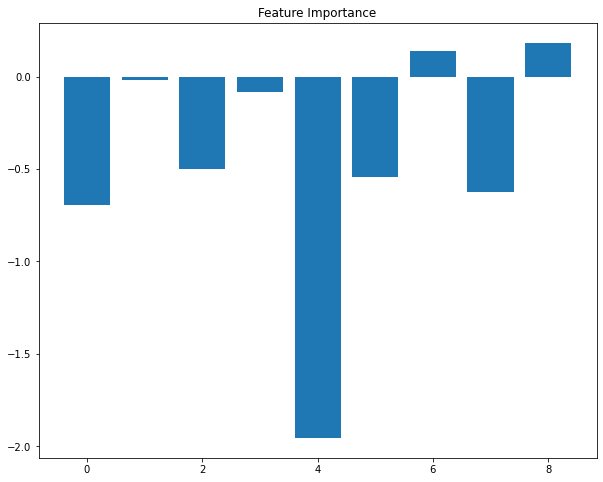

In [ ]:
importance = model_log.coef_[0]
cols = X_train_org.columns
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature {} - {}, Score: {:5f}'.format(i, cols[i],v))
# plot feature importance
plt.rcParams["figure.figsize"] = [10, 8]
plt.bar([x for x in range(len(importance))], importance)
plt.title("Feature Importance")
plt.show()

## PCA

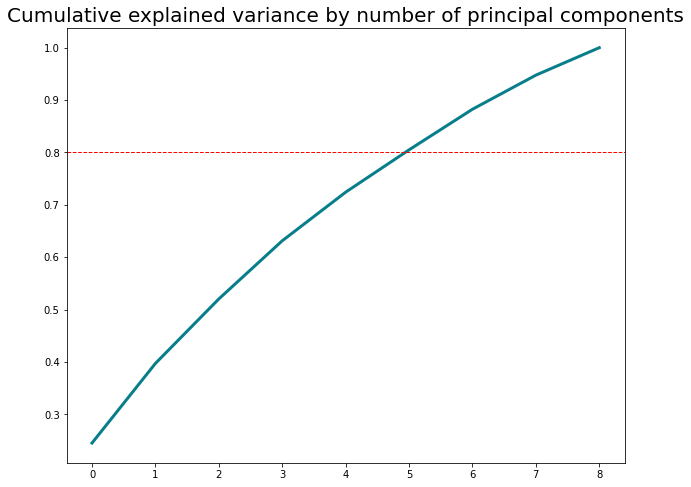

In [ ]:
pca = PCA().fit(X_train_log)

plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components', size=20)
plt.axhline(0.8, color="red", linestyle="dashed", linewidth=1)
plt.show()

In [ ]:
pca.explained_variance_

array([2.20613981, 1.36807394, 1.10819845, 0.99915642, 0.83535246,
       0.72757765, 0.69783913, 0.58580021, 0.47208786])

In [ ]:
pca.feature_names_in_

array(['is_tv_subscriber', 'is_movie_package_subscriber',
       'subscription_age', 'bill_avg', 'remaining_contract',
       'is_contract', 'service_failure_count', 'download_avg',
       'download_over_limit'], dtype=object)

## Tuning hyperparameters

In [ ]:
# Creating an scaler object
std_slc = StandardScaler()

In [ ]:
# Creating a pca object
pca = PCA()

In [ ]:
# Creating a logistic regression object
logistic_Reg = LogisticRegression()

In [ ]:
# Creating a pipeline of three steps. First, standardizing the data.
# Second, tranforming the data with PCA.
# Third, training a logistic regression on the data.
pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('pca', pca),
                           ('logistic_Reg', logistic_Reg)])

In [ ]:
X.shape[1]

10

In [ ]:
# Creating Parameter Space
# Creating a list of a sequence of integers from 1 to 11 (the number of features in X + 1)
n_components = list(range(1,X.shape[1]+1,1))
# Creating a list of values of the regularization parameter
C = np.logspace(-4, 4, 50)
# Creating a list of options for the regularization penalty
penalty = ['l1', 'l2']
# Creating a dictionary of all the parameter options
# Note has we can access the parameters of steps of a pipeline by using '__’
parameters = dict(pca__n_components=n_components,
                      logistic_Reg__C=C,
                      logistic_Reg__penalty=penalty)

In [ ]:
# Conducting Parameter Optmization With Pipeline
# Creating a grid search object
clf_GS = GridSearchCV(pipe, parameters)

# Fitting the grid search
clf_GS.fit(X, y)
# Viewing The Best Parameters
print('Best Penalty:', clf_GS.best_estimator_.get_params()['logistic_Reg__penalty'])
print('Best C:', clf_GS.best_estimator_.get_params()['logistic_Reg__C'])
print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
print(); print(clf_GS.best_estimator_.get_params()['logistic_Reg'])

Best Penalty: l2
Best C: 0.5689866029018293
Best Number Of Components: 10

LogisticRegression(C=0.5689866029018293)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
2500 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2500 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)

##Model selection

In [ ]:
#create df to compare models
df_train_exp = pd.DataFrame(columns=['Features', 'Number of features', 'AIC', 'Accuracy'])

In [ ]:
#function to get features of a model and its AIC and add its to df models
def getFeatures(x_vars, model, df):
  feat = "y ~ "
  #get features
  for i in range(len(x_vars.columns)):
    if i < len(x_vars.columns) - 1:
      feat += x_vars.columns[i] + " + "
    else:
      feat += x_vars.columns[i]

  y_pred = model.predict(X_test[x_vars.columns])
  y_pred = (y_pred>0.5)
  acc = accuracy_score(y_test, y_pred)

  row = [feat, len(x_vars.columns), model.aic, acc]
        #  , acc

  #append features and aic
  df.loc[len(df)] = row

In [ ]:
def build_lr_sm(X_train):
  model_logit = sm.Logit(y_train, X_train)
  result = model_logit.fit()
  return result

In [ ]:
# num_features_ = [ 'subscription_age', 'bill_avg', 'remaining_contract',
#        'service_failure_count', 'download_avg', 'download_over_limit']
# X_train[num_features_] = scaler.fit_transform(X_train[num_features_])
# X_test[num_features_] = scaler.fit_transform(X_test[num_features_])
# X_train

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,is_contract,service_failure_count,download_avg,download_over_limit
41444,1,0,-0.110551,0.639054,-0.736280,0,1.181516,0.700421,-0.133178
43171,1,0,0.458436,0.354100,0.755664,1,-0.357825,-0.174079,-0.133178
18811,1,0,0.325269,0.781531,-0.736280,0,-0.357825,-0.673793,-0.133178
40894,1,0,0.585551,-0.785716,0.499472,1,2.720857,0.545904,-0.133178
26477,1,0,-0.158976,-0.785716,-0.736280,1,5.799539,0.273034,-0.133178
...,...,...,...,...,...,...,...,...,...
69071,1,0,-0.691645,0.639054,-0.585579,1,-0.357825,-0.953239,-0.133178
49280,1,0,0.004457,0.211623,1.900995,1,-0.357825,-0.420648,-0.133178
1867,0,0,0.034722,0.781531,-0.736280,0,-0.357825,-1.038716,-0.133178
22549,1,0,1.166644,0.781531,-0.736280,0,-0.357825,3.307484,-0.133178


In [ ]:
#training
x = sm.add_constant(X)
model_logit1 = sm.Logit(y_train, X_train_log)
result1 = model_logit1.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.324007
         Iterations 7


In [ ]:
result1.aic
getFeatures(X_train_log, result1, df_train_exp)
df_train_exp

,Features,Number of features,AIC,Accuracy
0,y ~ is_tv_subscriber + is_movie_package_subscr...,9,25832.28751,0.87694


In [ ]:
# result6 = build_lr_sm(X_train.drop([], axis=1))
# getFeatures(X_train.drop([], axis=1), result6, df_train_exp)
# df_train_exp

Optimization terminated successfully.
         Current function value: 0.341170
         Iterations 7


,Features,Number of features,AIC,Accuracy
0,y ~ is_tv_subscriber + is_movie_package_subscr...,9,27199.71448,0.87653
1,y ~ is_tv_subscriber + is_movie_package_subscr...,9,27199.71448,0.87653


In [ ]:
result2 = build_lr_sm(X_train_log.drop(['download_over_limit'], axis=1))
getFeatures(X_train_log.drop(['download_over_limit'], axis=1), result2, df_train_exp)
df_train_exp

Optimization terminated successfully.
         Current function value: 0.324333
         Iterations 7


,Features,Number of features,AIC,Accuracy
0,y ~ is_tv_subscriber + is_movie_package_subscr...,9,25832.287510,0.876940
1,y ~ is_tv_subscriber + is_movie_package_subscr...,8,27271.081557,0.876237
2,y ~ is_tv_subscriber + is_movie_package_subscr...,8,27271.081557,0.876237
3,y ~ is_tv_subscriber + is_movie_package_subscr...,8,25856.279343,0.876237


In [ ]:
result3 = build_lr_sm(X_train_log.drop(['download_over_limit','download_avg'], axis=1))
getFeatures(X_train_log.drop(['download_over_limit','download_avg'], axis=1), result3, df_train_exp)
df_train_exp

Optimization terminated successfully.
         Current function value: 0.340978
         Iterations 7


,Features,Number of features,AIC,Accuracy
0,y ~ is_tv_subscriber + is_movie_package_subscr...,9,25832.287510,0.876940
1,y ~ is_tv_subscriber + is_movie_package_subscr...,8,27271.081557,0.876237
2,y ~ is_tv_subscriber + is_movie_package_subscr...,8,27271.081557,0.876237
3,y ~ is_tv_subscriber + is_movie_package_subscr...,8,25856.279343,0.876237
4,y ~ is_tv_subscriber + is_movie_package_subscr...,7,27180.368349,0.876413


In [ ]:
result4 = build_lr_sm(X_train_log.drop(['download_over_limit','download_avg', 'service_failure_count'], axis=1))
getFeatures(X_train_log.drop(['download_over_limit','download_avg', 'service_failure_count'], axis=1), result4, df_train_exp)
df_train_exp

Optimization terminated successfully.
         Current function value: 0.341557
         Iterations 7


,Features,Number of features,AIC,Accuracy
0,y ~ is_tv_subscriber + is_movie_package_subscr...,9,25832.287510,0.876940
1,y ~ is_tv_subscriber + is_movie_package_subscr...,8,27271.081557,0.876237
2,y ~ is_tv_subscriber + is_movie_package_subscr...,8,27271.081557,0.876237
3,y ~ is_tv_subscriber + is_movie_package_subscr...,8,25856.279343,0.876237
4,y ~ is_tv_subscriber + is_movie_package_subscr...,7,27180.368349,0.876413
5,y ~ is_tv_subscriber + is_movie_package_subscr...,6,27224.542452,0.877350


In [ ]:
result5 = build_lr_sm(X_train_log.drop(['download_over_limit','download_avg', 'service_failure_count','is_contract'], axis=1))
getFeatures(X_train_log.drop(['download_over_limit','download_avg', 'service_failure_count','is_contract'], axis=1), result5, df_train_exp)
df_train_exp

Optimization terminated successfully.
         Current function value: 0.352274
         Iterations 7


,Features,Number of features,AIC,Accuracy
0,y ~ is_tv_subscriber + is_movie_package_subscr...,9,25832.287510,0.876940
1,y ~ is_tv_subscriber + is_movie_package_subscr...,8,27271.081557,0.876237
2,y ~ is_tv_subscriber + is_movie_package_subscr...,8,27271.081557,0.876237
3,y ~ is_tv_subscriber + is_movie_package_subscr...,8,25856.279343,0.876237
4,y ~ is_tv_subscriber + is_movie_package_subscr...,7,27180.368349,0.876413
5,y ~ is_tv_subscriber + is_movie_package_subscr...,6,27224.542452,0.877350
6,y ~ is_tv_subscriber + is_movie_package_subscr...,5,28076.364324,0.887776


In [ ]:
df_train_exp.to_csv('/content/gdrive/Shareddrives/DA with R-Python/0.Project/Source code/asset/logit_train.csv', index=False, header=True)

# Decision Tree

In [ ]:
# Initialize decision tree classifier
dt = DecisionTreeClassifier()

# Fit the decision tree on training data
dt.fit(X_train, y_train)

# Predict churn labels on testing data
pred_test_Y = dt.predict(X_test)

# Print result
print(classification_report(y_test, pred_test_Y))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      7193
           1       0.93      0.93      0.93      9880

    accuracy                           0.92     17073
   macro avg       0.92      0.92      0.92     17073
weighted avg       0.92      0.92      0.92     17073



In [ ]:
# Predict churn labels on trainig data
pred_train_Y = dt.predict(X_train)

# Print result
print(classification_report(y_train, pred_train_Y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16846
           1       1.00      1.00      1.00     22991

    accuracy                           1.00     39837
   macro avg       1.00      1.00      1.00     39837
weighted avg       1.00      1.00      1.00     39837



Overfitting

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor()
regr.fit(X_train, y_train)

# Predict churn labels on testing data
pred_test_Y = dt.predict(X_test)

# Print result
print(classification_report(y_test, pred_test_Y))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      7193
           1       0.92      0.93      0.93      9880

    accuracy                           0.92     17073
   macro avg       0.91      0.91      0.91     17073
weighted avg       0.92      0.92      0.92     17073



In [ ]:

# Predict churn labels on testing data
pred_train_Y = dt.predict(X_train)

# Print result
print(classification_report(y_train, pred_train_Y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16846
           1       1.00      1.00      1.00     22991

    accuracy                           1.00     39837
   macro avg       1.00      1.00      1.00     39837
weighted avg       1.00      1.00      1.00     39837



# Dealing with overfitting

If the performance of the model on the training dataset is significantly better than the performance on the test dataset, then the model may have overfit the training dataset. This is because the model is memorizing the data it has seen and is unable to generalize to unseen examples.

1, train: 0.926, test: 0.925
2, train: 0.941, test: 0.939
3, train: 0.947, test: 0.946
4, train: 0.947, test: 0.946
5, train: 0.948, test: 0.947
6, train: 0.951, test: 0.948
7, train: 0.957, test: 0.956
8, train: 0.959, test: 0.957
9, train: 0.961, test: 0.959
10, train: 0.970, test: 0.966
11, train: 0.972, test: 0.966
12, train: 0.976, test: 0.967
13, train: 0.978, test: 0.968
14, train: 0.983, test: 0.970
15, train: 0.986, test: 0.970
16, train: 0.989, test: 0.972
17, train: 0.991, test: 0.972
18, train: 0.993, test: 0.973
19, train: 0.994, test: 0.973
20, train: 0.996, test: 0.974
21, train: 0.997, test: 0.974
22, train: 0.998, test: 0.975
23, train: 0.999, test: 0.975
24, train: 0.999, test: 0.975
25, train: 0.999, test: 0.975
26, train: 1.000, test: 0.976
27, train: 1.000, test: 0.975
28, train: 1.000, test: 0.975
29, train: 1.000, test: 0.975


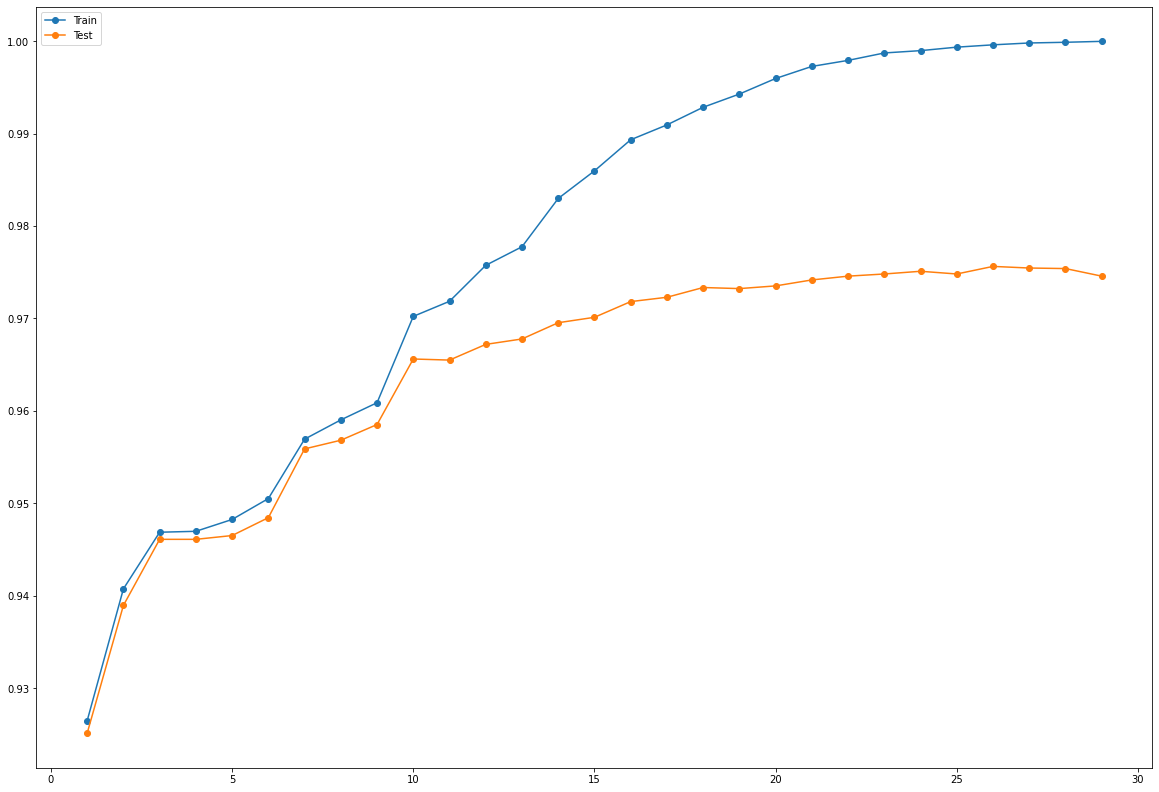

In [ ]:
# define lists to collect scores
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 30)]
# evaluate a decision tree for each depth
for i in values:
	# configure the model
	model = DecisionTreeClassifier(max_depth=i)
	# fit model on the training dataset
	model.fit(X_train, y_train)
	# evaluate on the train dataset
	train_yhat = model.predict(X_train)
	train_acc = accuracy_score(y_train, train_yhat)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	test_yhat = model.predict(X_test)
	test_acc = accuracy_score(y_test, test_yhat)
	test_scores.append(test_acc)
	# summarize progress
	print('%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

## DecisionTree hyper parameter optimization using Grid Search


In [ ]:
#std_slc = StandardScaler()
pca = decomposition.PCA()
dec_tree = DecisionTreeClassifier()

**Using Pipeline for GridSearch**

Pipeline will helps us by passing modules one by one through GridSearchCV for which we want to get the best parameters. So we are making an object pipe to create a pipeline for all the three objects std_scl, pca and dec_tree.

In [ ]:
pipe = Pipeline(steps=[('pca', pca),
                      ('dec_tree', dec_tree)])

In [ ]:
n_components = list(range(1,X_train.shape[1]+1,1))
criterion = ['gini', 'entropy']
max_depth = [4,6,8,10,12]

In [ ]:
parameters = dict(pca__n_components=n_components,
                  dec_tree__criterion=criterion,
                  dec_tree__max_depth=max_depth)

In [ ]:
clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                       ('dec_tree', DecisionTreeClassifier())]),
             param_grid={'dec_tree__criterion': ['gini', 'entropy'],
                         'dec_tree__max_depth': [4, 6, 8, 10, 12],
                         'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11]})

In [ ]:
print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
print(clf_GS.best_estimator_.get_params()['dec_tree'])

Best Criterion: entropy
Best max_depth: 12
Best Number Of Components: 11
DecisionTreeClassifier(criterion='entropy', max_depth=12)


In [ ]:
# Initialize decision tree classifier
dt = DecisionTreeClassifier(criterion='entropy', max_depth=10)

# Fit the decision tree on training data
dt.fit(X_train, y_train)

# Predict churn labels on testing data
pred_test_Y = dt.predict(X_test)

# Print result
print(classification_report(y_test, pred_test_Y))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      7193
           1       0.95      0.94      0.95      9880

    accuracy                           0.94     17073
   macro avg       0.94      0.94      0.94     17073
weighted avg       0.94      0.94      0.94     17073



In [ ]:
# Predict churn labels on testing data
pred_train_Y = dt.predict(X_train)

# Print result
print(classification_report(y_train, pred_train_Y))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     16846
           1       0.97      0.95      0.96     22991

    accuracy                           0.95     39837
   macro avg       0.95      0.95      0.95     39837
weighted avg       0.95      0.95      0.95     39837



## Random Forest hyper parameter

In [ ]:
pipe = Pipeline([("classifier", RandomForestClassifier())])

search_space = [{"classifier": [RandomForestClassifier()],
                                "classifier__n_estimators": [10, 100, 1000],
                                "classifier__max_features": [1, 2, 3]}]

* param_grid: Dictionary or list of parameters of models or function in which GridSearchCV have to select the best.

* cv : In this we have to pass a interger value, as it signifies the number of splits that is needed for cross validation. By default is set as five.

* n_jobs : This signifies the number of jobs to be run in parallel, -1 signifies to use all processor.

In [ ]:
clf = GridSearchCV(pipe, search_space, cv=5, verbose=0, n_jobs = -1)
best_model = clf.fit(X, y)

/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
print(best_model.best_estimator_.get_params()["classifier"])

RandomForestClassifier(max_features=1, n_estimators=10)


In [ ]:
regr = RandomForestRegressor(max_features=1, n_estimators=10)
regr.fit(X_train, y_train)

# Predict churn labels on testing data
pred_test_Y = regr.predict(X_test)

# Print result
print(classification_report(y_test, (pred_test_Y > 0.5)))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      7193
           1       0.97      0.93      0.95      9880

    accuracy                           0.94     17073
   macro avg       0.94      0.94      0.94     17073
weighted avg       0.94      0.94      0.94     17073



In [ ]:
accuracy_score(y_test, (pred_test_Y > 0.5))

0.9410765536226791

In [ ]:
# Predict churn labels on training data
pred_train_Y = regr.predict(X_train)

# Print result
print(classification_report(y_train, (pred_train_Y > 0.5)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     16846
           1       1.00      0.99      0.99     22991

    accuracy                           0.99     39837
   macro avg       0.99      0.99      0.99     39837
weighted avg       0.99      0.99      0.99     39837



#ANN

https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

There are many rule-of-thumb methods for determining the correct number of neurons to use in the hidden layers, such as the following:

* The number of hidden neurons should be between the size of the input layer and the size of the output layer.
* The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
* The number of hidden neurons should be less than twice the size of the input layer.

• Number of hidden nodes: There is no magic formula for selecting the optimum number of hidden neurons. However, some thumb rules are available for calculating the number of hidden neurons. A rough approximation can be obtained by the geometric pyramid rule proposed by Masters (1993). For a three layer network with n input and m output neurons, the hidden layer would have n∗m−−−−−√ neurons.

In [ ]:
def add_exp(df, name, optimizer, epochs, batch, num_layers, data, train_acc, test_acc):
  arr = [name, optimizer, epochs, batch, num_layers, data, train_acc, test_acc]
  df.loc[len(df)] = arr
  return df
  # return pd.concat([arr, df.loc[:]]).reset_index(drop=True)

In [ ]:
def setup_layers(input):
  ann = Sequential()
  # adding the input layer and the first hidden layer
  ann.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu', input_dim = input))

  # adding the second hidden layer
  ann.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

  # adding the output layer
  ann.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
  return ann

In [ ]:
def modeling_ann(x_train, y_train, input, epoch, batch):
  ann = setup_layers(input)
  #complie
  ann.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  # fit the model
  ann.fit(x_train, y_train, batch_size = batch, epochs = epoch, verbose = 0)
  return ann

In [ ]:
def modeling_ann_dropout(x_train, y_train, input, epoch, batch):
  ann = Sequential()
  # adding the input layer and the first hidden layer
  ann.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu', input_dim = input))
  ann.add(Dropout(rate = 0.2))

  # adding the second hidden layer
  ann.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
  ann.add(Dropout(rate = 0.2))

  # adding the output layer
  ann.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

  #complie
  ann.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  # fit the model
  ann.fit(x_train, y_train, batch_size = batch, epochs = epoch, verbose = 0)

  return ann

In [ ]:
def modeling_ann_earlystopping(x_train, y_train, input, epoch, batch):
  ann = setup_layers(input)

  # add early stopping
  early_stopping = keras.callbacks.EarlyStopping(
      monitor='val_loss', min_delta=0, patience=5, verbose=0,
      mode='auto', baseline=None, restore_best_weights= True
  )
  ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # fit
  ann.fit(x_train, y_train, epochs=epoch, batch_size = batch, callbacks = early_stopping, validation_split=0.20)
  return ann

In [ ]:
def get_scores(model, x_test, y_test):
  y_pred = model.predict(x_test)
  y_pred = (y_pred > 0.5)
  score, acc = model.evaluate(x_test, y_test)
  print(classification_report(y_test,y_pred))
  return score, acc

In [ ]:
df_exp = pd.DataFrame(columns=['name', 'optimizer', 'epochs', 'bacth', 'num_hidden_layers', 'dataset','accuracy_train', 'accuracy_test'])
df_exp

,name,optimizer,epochs,bacth,num_hidden_layers,dataset,accuracy_train,accuracy_test


##No scaling

In [ ]:
X_train_org.shape

(39837, 10)

In [ ]:
ann_mixed = modeling_ann(X_train_org, y_train, 10, 10, 16)
loss_test, acc_test = get_scores(ann_mixed, X_test_org, y_test)

534/534 [==============================] - 1s 1ms/step - loss: 0.2539 - accuracy: 0.9107
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      7184
           1       0.96      0.88      0.92      9889

    accuracy                           0.91     17073
   macro avg       0.91      0.92      0.91     17073
weighted avg       0.92      0.91      0.91     17073



In [ ]:
loss_train, acc_train = get_scores(ann_mixed, X_train_org, y_train)

1245/1245 [==============================] - 2s 1ms/step - loss: 0.2477 - accuracy: 0.9136
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     16855
           1       0.96      0.89      0.92     22981

    accuracy                           0.91     39836
   macro avg       0.91      0.92      0.91     39836
weighted avg       0.92      0.91      0.91     39836



In [ ]:
df_exp = add_exp(df_exp, 'ANN ', 'adam', 10, 16, 4, 'mixed', acc_train, acc_test)
df_exp

,name,optimizer,epochs,bacth,num_hidden_layers,dataset,accuracy_train,accuracy_test
0,ANN standardscale,adam,10,16,4,mixed,0.926423,0.924149
1,ANN,adam,10,16,4,mixed,0.913646,0.910736


In [ ]:
#cross validation
def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 10))
    classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 16, epochs = 20,verbose=0)
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

<ipython-input-55-af50f8aaa72b>:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = build_classifier, batch_size = 16, epochs = 20,verbose=0)


In [ ]:
mean = accuracies.mean()
variance = accuracies.std()
print(mean, variance)

0.9314686954021454 0.007074632704281848


##Scaling - Standardization

Consider not using Normalization which can be affected by outliers

In [ ]:
scale = StandardScaler()
num_features= ['subscription_age', 'bill_avg', 'remaining_contract','service_failure_count', 'download_avg', 'upload_avg','download_over_limit']
# x_train_sc3 = x_train3
# x_test_sc3 = x_test3
# x_train_sc3[num_features] = scale.fit_transform(x_train3[num_features])
# x_test_sc3[num_features] = scale.transform(x_test3[num_features])
# x_train_sc3

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,is_contract,service_failure_count,download_avg,upload_avg,download_over_limit
31685,1,0,-0.110551,0.639054,-0.736280,0,1.181516,0.700421,-0.043321,-0.133178
33134,1,0,0.458436,0.354100,0.755664,1,-0.357825,-0.174079,-0.645793,-0.133178
12589,1,0,0.325269,0.781531,-0.736280,0,-0.357825,-0.673793,0.085780,-0.133178
31243,1,0,0.585551,-0.785716,0.499472,1,2.720857,0.545904,-0.129389,-0.133178
19145,1,0,-0.158976,-0.785716,-0.736280,1,5.799539,0.273034,-0.086355,-0.133178
...,...,...,...,...,...,...,...,...,...,...
54343,1,0,-0.691645,0.639054,-0.585579,1,-0.357825,-0.953239,-0.947030,-0.133178
38158,1,0,0.004457,0.211623,1.900995,1,-0.357825,-0.420648,-0.172422,-0.133178
860,0,0,0.034722,0.781531,-0.736280,0,-0.357825,-1.038716,-1.033097,-0.133178
15795,1,0,1.166644,0.781531,-0.736280,0,-0.357825,3.307484,2.926007,-0.133178


In [ ]:
ann_mixed_sc = modeling_ann(X_train, y_train,  10, 10, 16)

In [ ]:
score_test, acc_test = get_scores(ann_mixed_sc, X_test, y_test)
score_train, acc_train = get_scores(ann_mixed_sc, X_train, y_train)

534/534 [==============================] - 1s 1ms/step - loss: 0.2406 - accuracy: 0.9293
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      7193
           1       0.95      0.93      0.94      9880

    accuracy                           0.93     17073
   macro avg       0.93      0.93      0.93     17073
weighted avg       0.93      0.93      0.93     17073

1245/1245 [==============================] - 2s 1ms/step - loss: 0.2363 - accuracy: 0.9308
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     16846
           1       0.95      0.93      0.94     22991

    accuracy                           0.93     39837
   macro avg       0.93      0.93      0.93     39837
weighted avg       0.93      0.93      0.93     39837



In [ ]:
df_exp = add_exp(df_exp, 'ANN standardscale', 'adam', 10, 16, 4, 'mixed', acc_train, acc_test)
df_exp

,name,optimizer,epochs,bacth,num_hidden_layers,dataset,accuracy_train,accuracy_test
0,ANN standardscale,adam,10,16,4,mixed,0.926423,0.924149


##Handling overfitting

https://machinelearningcoban.com/2017/03/04/overfitting/#-validation

### Early stopping

In [ ]:
ann = Sequential()
# adding the input layer and the first hidden layer
ann.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 10))

# adding the second hidden layer
ann.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
# adding the output layer
ann.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights= True
)
ann.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])

# fit
history = ann.fit(X_train, y_train, epochs=100, batch_size = 16
        , callbacks = early_stopping, validation_split=0.20
        )
# classifier.fit(X_train, y_train, batch_size = 32, epochs = 100,verbose = 0)


Epoch 1/100
1992/1992 [==============================] - 11s 5ms/step - loss: 0.3378 - accuracy: 0.8726 - auc: 0.9294 - val_loss: 0.2957 - val_accuracy: 0.8950 - val_auc: 0.9370
Epoch 2/100
1992/1992 [==============================] - 12s 6ms/step - loss: 0.2755 - accuracy: 0.9038 - auc: 0.9451 - val_loss: 0.2855 - val_accuracy: 0.9026 - val_auc: 0.9400
Epoch 3/100
1992/1992 [==============================] - 10s 5ms/step - loss: 0.2664 - accuracy: 0.9075 - auc: 0.9480 - val_loss: 0.2770 - val_accuracy: 0.9065 - val_auc: 0.9430
Epoch 4/100
1992/1992 [==============================] - 6s 3ms/step - loss: 0.2579 - accuracy: 0.9114 - auc: 0.9508 - val_loss: 0.2683 - val_accuracy: 0.9075 - val_auc: 0.9472
Epoch 5/100
1992/1992 [==============================] - 11s 5ms/step - loss: 0.2509 - accuracy: 0.9137 - auc: 0.9535 - val_loss: 0.2620 - val_accuracy: 0.9114 - val_auc: 0.9494
Epoch 6/100
1992/1992 [==============================] - 9s 4ms/step - loss: 0.2448 - accuracy: 0.9172 - auc: 0

In [ ]:
score_test = get_scores(ann, X_test, y_test)
score_train = get_scores(ann, X_train, y_train)

534/534 [==============================] - 1s 2ms/step - loss: 0.2214 - accuracy: 0.9298 - auc: 0.9613


ValueError: ignored

In [ ]:
y_pred = ann.predict(X_test)
y_pred = (y_pred > 0.5)
test_score, test_acc, test_auc = ann.evaluate(X_test, y_test)
print(classification_report(y_test,y_pred))

534/534 [==============================] - 2s 3ms/step - loss: 0.2214 - accuracy: 0.9298 - auc: 0.9613
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7193
           1       0.96      0.92      0.94      9880

    accuracy                           0.93     17073
   macro avg       0.93      0.93      0.93     17073
weighted avg       0.93      0.93      0.93     17073



In [ ]:
train_score, train_acc, auc = ann.evaluate(X_train, y_train)

1245/1245 [==============================] - 4s 3ms/step - loss: 0.2155 - accuracy: 0.9311 - auc: 0.9627


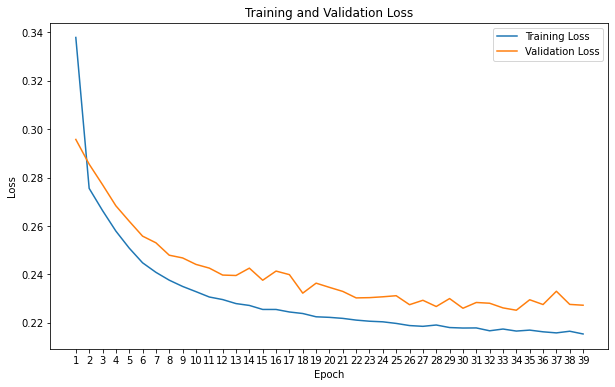

In [ ]:
plt.figure(figsize=(10, 6))

epochs = range(1, 39 + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()

plt.show()

In [ ]:
np.argmin(val_loss)

33

In [ ]:
df_exp = add_exp(df_exp, 'ANN early_stopping', 'adam', 100, 16, 4, 'mixed', acc_train, acc_test)
df_exp

,name,optimizer,epochs,bacth,num_hidden_layers,dataset,accuracy_train,accuracy_test
0,ANN,adam,10,16,4,df2575,0.922678,0.918982
1,ANN minmaxscale,adam,10,16,4,df2575,0.841600,0.837398
2,ANN,adam,10,16,4,df0595,0.917984,0.918279
3,ANN,adam,10,16,4,mixed,0.922482,0.921513
4,ANN minmaxscale,adam,10,16,4,mixed,0.842806,0.841036
5,ANN early_stopping,adam,100,16,4,mixed,0.938749,0.937211


###Dropout

In [ ]:
ann_dropout = modeling_ann_dropout(X_train, y_train, 10, 20, 32)

In [ ]:
score_test, acc_test = get_scores(ann, X_test, y_test)
score_train, acc_train = get_scores(ann, x_train, y_train)
df_exp = add_exp(df_exp, 'ANN dropout', 'adam', 20, 32, 4, 'mixed', acc_train, acc_test)
df_exp

534/534 [==============================] - 1s 2ms/step - loss: 0.2078 - accuracy: 0.9372
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      7184
           1       0.95      0.94      0.95      9889

    accuracy                           0.94     17073
   macro avg       0.93      0.94      0.94     17073
weighted avg       0.94      0.94      0.94     17073

1245/1245 [==============================] - 2s 2ms/step - loss: 0.2000 - accuracy: 0.9387
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     16855
           1       0.95      0.94      0.95     22981

    accuracy                           0.94     39836
   macro avg       0.94      0.94      0.94     39836
weighted avg       0.94      0.94      0.94     39836



,name,optimizer,epochs,bacth,num_hidden_layers,dataset,accuracy_train,accuracy_test
0,ANN,adam,10,16,4,df2575,0.922678,0.918982
1,ANN minmaxscale,adam,10,16,4,df2575,0.841600,0.837398
2,ANN,adam,10,16,4,df0595,0.917984,0.918279
3,ANN,adam,10,16,4,mixed,0.922482,0.921513
4,ANN minmaxscale,adam,10,16,4,mixed,0.842806,0.841036
5,ANN early_stopping,adam,100,16,4,mixed,0.938749,0.937211
6,ANN dropout,adam,20,16,4,mixed,0.938749,0.937211
7,ANN dropout,adam,20,32,4,mixed,0.938749,0.937211
8,ANN dropout,adam,20,32,4,mixed,0.938749,0.937211


##Tuning


Need to get optimal parameters (epochs, batch_size, optimizer)




```
from sklearn.model_selection import GridSearchCV

```



In [ ]:
df_exp

,name,optimizer,epochs,bacth,num_hidden_layers,dataset,accuracy_train,accuracy_test
0,ANN,adam,10,16,4,df2575,0.922678,0.918982
1,ANN minmaxscale,adam,10,16,4,df2575,0.841600,0.837398
2,ANN,adam,10,16,4,df0595,0.917984,0.918279
3,ANN,adam,10,16,4,mixed,0.922482,0.921513
5,ANN early_stopping,adam,100,16,4,mixed,0.938749,0.937211
6,ANN dropout,adam,20,16,4,mixed,0.938749,0.937211
7,ANN dropout,adam,20,32,4,mixed,0.938749,0.937211
8,ANN dropout,adam,20,32,4,mixed,0.938749,0.937211
9,ANN minmaxscale,adam,10,16,4,mixed,0.925469,0.924442
10,ANN standardscale,adam,10,16,4,mixed,0.932046,0.929655


In [ ]:
from sklearn.model_selection import GridSearchCV
def build_classifier(optimizer):
    classifier = setup_layers(10)
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [16, 32],
              'epochs': [10, 20, 30],
              'optimizer': ['adam']}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5)
grid_search = grid_search.fit(X_train, y_train,verbose = 0)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


249/249 [==============================] - 0s 1ms/step


In [ ]:
print('Best Parameters: {}'.format(best_parameters))
print('Best Accuracy: {}'.format(best_accuracy))

Best Parameters: {'batch_size': 16, 'epochs': 30, 'optimizer': 'adam'}
Best Accuracy: 0.9331257186395889


In [ ]:
# df_exp.to_csv(path+"anns_df_exp"+datetime.now().strftime('%Y-%m-%d')+".csv", header=True, index=False)

##Final model

In [ ]:
ann = modeling_ann(X_train, y_train, 10, 30, 16)

In [ ]:
loss, acc = get_scores(ann, X_test, y_test)

534/534 [==============================] - 1s 1ms/step - loss: 0.2172 - accuracy: 0.9295
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7193
           1       0.95      0.92      0.94      9880

    accuracy                           0.93     17073
   macro avg       0.93      0.93      0.93     17073
weighted avg       0.93      0.93      0.93     17073



In [ ]:
acc

0.9295378923416138

# Evaluation

In [ ]:
def plot_roc(model, name_of_model, X_train, X_test):
  # model = LogisticRegression()
  model.fit(X_train, y_train)

  y_pred = model.predict_proba(X_test)[:,1]
  # print(roc_auc_score(y_test, model.predict_proba[:,1]))
  fpr, tpr, _ = roc_curve(y_test, y_pred)
  return fpr, tpr, _

In [ ]:
logit = LogisticRegression()
logit.fit(X_train_log, y_train)

y_pred = logit.predict_proba(X_test_log)[:,1]
print(roc_auc_score(y_test, y_pred))

fpr1, tpr1, threshold1 = roc_curve(y_test, y_pred)

# plt.clf()
# plt.plot(fpr, tpr)
# plt.xlabel('FPR')
# plt.ylabel('TPR')
# plt.title('ROC curve')
# # plt.legend(handles = roc_auc_score(y_test, y_pred), loc='upper right')
# plt.show()

0.936245638612889


In [ ]:
fpr2, tpr2, threshold2 = plot_roc(dt, 'Decision Tree', X_train, X_test)

In [ ]:
# fpr3, tpr3, threshold3 = plot_roc(regr, 'Random Forest', X_train, X_test)
regr = RandomForestClassifier(max_features=1, n_estimators=10)
fpr3, tpr3, threshold3 = plot_roc(regr, 'Random Forest', X_train, X_test)

In [ ]:
# fpr4, tpr4, threshold4 = plot_roc(ann, 'ANN', X_train, X_test)
y_pred_ann = ann.predict(X_test).ravel()
fpr4, tpr4, threshold4 = roc_curve(y_test, y_pred_ann)

534/534 [==============================] - 2s 4ms/step


https://stackoverflow.com/questions/52653320/predict-proba-method-of-keras-model-does-not-exist

Text(0.5, 1.0, 'Receiver Operating Characteristic')

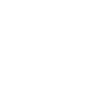

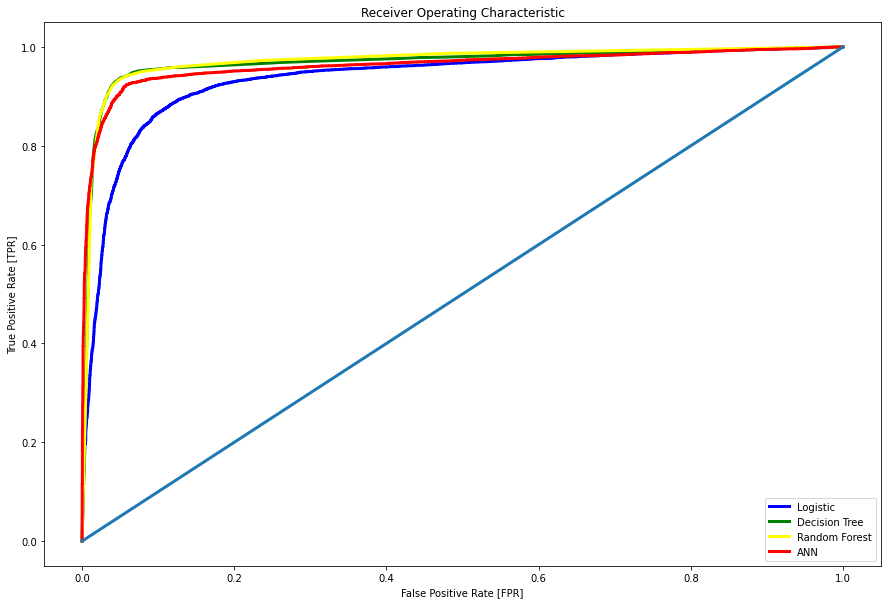

In [ ]:
plt.figure(figsize=(1,1))
ax = plt.gca()
ax.set_visible(False)

# Get series labels as numpy list
# _, labels = ax.get_legend_handles_labels()
# labels = np.array(labels)
labels = ['Logistic', 'Decision Tree','Random Forest', 'ANN']
# Create plot yourself
fig = plt.figure(figsize=(15,10))
plt.plot(fpr1, tpr1, 'b', linewidth=3)
plt.plot(fpr2, tpr2, 'g', linewidth=3)
plt.plot(fpr3, tpr3, 'yellow', linewidth=3)
plt.plot(fpr4, tpr4, 'r', linewidth=3)
# plt.plot(fpr3, tpr3, 'purple', linewidth=3)
plt.plot(np.arange(0,1.01,0.01), np.arange(0,1.01,0.01), linewidth=3)
plt.legend(labels, loc='lower right')
plt.xlabel('False Positive Rate [FPR]')
plt.ylabel('True Positive Rate [TPR]')
plt.title('Receiver Operating Characteristic')